<a href="https://colab.research.google.com/github/kodai-utsunomiya/memorization-and-generalization/blob/main/Disentangling_feature_and_lazy_training_in_deep_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# アーキテクチャ

# <font color="green"> `FC` クラス </font>

### ネットワークの構造

1. **入力層**: 次元数 $d$ の入力を受け取る．
2. **隠れ層**: 層数 $L$ の隠れ層があり，各隠れ層のユニット数は $h$．
3. **出力層**: 最終層は出力がスカラー値である 1 次元のベクトルを生成．

<br>

### 層ごとの計算

1. **初期化**:
   - 隠れ層 $i$ の重み行列 $W_i$ は，次のように初期化：
     
     $
     W_i \sim \mathcal{N}(0, 1)
     $

     ここで，$W_i$ のサイズは $ h \times \text{hh}_{i}$ ．
     
     $\text{hh}_{i} $ は前の層の出力ユニット数．

   - メモリ効率を考慮し，重み行列を分割：
     
     $ W_i = $

     \begin{bmatrix}
     W_i^{(0)} \\
     W_i^{(1)} \\
     \vdots \\
     W_i^{(n-1)}
     \end{bmatrix}
     
     各部分行列 $W_i^{(j)}$ はサイズ $m \times \text{hh}_{i}$．ここで，$m$ は分割サイズ．

<br>

2. **順伝播計算**:
   - 入力テンソル $x$ は，初期の隠れ層で次のように変換：
     
     $
     x^{(0)} = x W_0^T / \sqrt{d}
     $

     ここで，$W_0$ は最初の隠れ層の重み行列．バイアス項がある場合，次のように加算：
     
     $
     x^{(0)} = x^{(0)} + b_0
     $

     その後，活性化関数 $ \sigma $ を適用：
     
     $
     x^{(1)} = \sigma(x^{(0)})
     $

   - 次の隠れ層も同様に計算．一般的に，隠れ層 $i$ の計算は次のようになる：
     
     $
     x^{(i)} = x^{(i-1)} W_i^T / \sqrt{h}
     $

     ここで，$W_i$ は現在の層の重み行列．バイアス項がある場合，次のように加算：

     $
     x^{(i)} = x^{(i)} + b_i
     $

     そして，活性化関数を適用：
     
     $
     x^{(i+1)} = \sigma(x^{(i)})
     $

   - 最終層では，次のように計算：
     
     $
     x^{(L)} = x^{(L-1)} W_L^T / h + b_L
     $
     
     ここで，$W_L$ は最終層の重み行列．出力テンソル $x$ を 1 次元に変換して返す：

     $
     x^{(L)} = x^{(L)} \text{view}(-1)
     $

<br>

### 要点

- **入力層**: $d$ 次元の入力を受け取る．
- **隠れ層**: 各層で線形変換と活性化関数を適用．線形変換は以下のようにスケーリング：
  
  $
  x^{(i)} = x^{(i-1)} W_i^T / \sqrt{h}
  $
- **出力層**: 最終層で線形変換を行い，スカラー値に変換：
  
  $
  x^{(L)} = x^{(L-1)} W_L^T / h + b_L
  $

# <font color="green">`Wide_ResNet` クラス </font>

### 1. ネットワークの構造

- 初期の畳み込み層
- 複数の Wide-ResNet ブロックからなるレイヤー
- 最終的な線形層

<br>

### 2. 初期の畳み込み層

最初に入力データ $ x $ に対して，畳み込み演算を行う：

$ \mathbf{z}_1 = \text{conv}(x) $

ここで，`conv` はカーネルサイズ $ 3 \times 3 $，ストライド $ 1 $，パディング $ 1 $ の畳み込み演算．出力のチャネル数は $ nStages[0] $．

<br>

### 3. Wide-ResNet レイヤー

`Wide_ResNet` は，複数の `wide_basic` ブロックからなるレイヤーを持つ．各レイヤーは以下のように定義：

- **ブロック数**: $ n $
- **ストライド**: 最初のブロックのストライドは `stride` で指定し，以降はすべてストライド $ 1 $

各レイヤー $ l $ は以下のように定義：

$ \mathbf{z}_l = \text{layer}_l(\mathbf{z}_{l-1}) $

ここで，`layer` は `self._wide_layer` メソッドによって定義し，複数の `wide_basic` ブロックがストライドに従って連結．

<br>

### 4. Wide-ResNet ブロック

`wide_basic` ブロック内での処理は次のように表される：

$ \mathbf{y} = \text{conv2}(\text{act}(\text{conv1}(\mathbf{x}))) $

ここで，$\text{conv1}$ と $\text{conv2}$ はそれぞれカーネルサイズ $ 3 \times 3 $ の畳み込み層であり，$\text{act}$ は活性化関数．

ショートカット接続の処理は次のように行う：

$ \text{shortcut} = \text{conv}_{shortcut}(\mathbf{x}) $

（ストライドやチャネル数が異なる場合のみ，1x1 畳み込みを適用．）

最終的な出力は，以下のように角度 $ \theta $ に基づく線形結合で計算：

$ \mathbf{z}_\text{out} = \cos(\theta) \cdot \text{shortcut} + \sin(\theta) \cdot \mathbf{y} $

ここで，角度 $\theta$ は `mix_angle` に基づいて計算され，ラジアンに変換：

$ \theta = \frac{\text{mix_angle} \times \pi}{180} $

<br>

### 5. 最終線形層

最終的な特徴マップ $\mathbf{z}_\text{final}$ は，全てのレイヤーを通過した後にフラット化し，平均化：

$ \mathbf{z}_\text{flat} = \text{flatten}(\mathbf{z}_\text{final}) $

$ \mathbf{z}_\text{avg} = \text{mean}(\mathbf{z}_\text{flat}, \text{dim}=2) $

最後に線形変換を適用し，クラス数 $ \text{num_classes} $ に基づく出力を得る：

$ \mathbf{z}_\text{output} = \mathbf{z}_\text{avg} \cdot \frac{\mathbf{W}}{h} + \mathbf{b} $

ここで，$\mathbf{W}$ は最終線形層の重み，$h$ は重みのサイズ，$\mathbf{b}$ はバイアス．

<br>

### 6. 出力のフラット化

もし最終的な出力の次元が $1$ の場合，出力をフラット化：

$ \mathbf{z}_\text{output} = \text{flatten}(\mathbf{z}_\text{output}, \text{dim}=0) $

<br>

### まとめ

Wide-ResNet の全体的な流れ：

1. **初期の畳み込み層**:
   $ \mathbf{z}_1 = \text{conv}(x) $

2. **Wide-ResNet レイヤー**:

   $ \mathbf{z}_l = \text{layer}_l(\mathbf{z}_{l-1}) \text{ for } l = 1, 2, 3 $

3. **Wide-ResNet ブロック**:

   $ \mathbf{z}_\text{out} = \cos(\theta) \cdot \text{shortcut} + \sin(\theta) \cdot \mathbf{y} $

4. **最終線形層**:

   $ \mathbf{z}_\text{avg} = \text{mean}(\text{flatten}(\mathbf{z}_\text{final}), \text{dim}=2) $

   $ \mathbf{z}_\text{output} = \mathbf{z}_\text{avg} \cdot \frac{\mathbf{W}}{h} + \mathbf{b} $

5. **出力のフラット化**（必要に応じて）:

   $ \mathbf{z}_\text{output} = \text{flatten}(\mathbf{z}_\text{output}, \text{dim}=0) $

In [2]:
# pylint: disable=E1101, C, arguments-differ
"""
Defines three architectures:
- Fully connecetd `FC`
- Convolutional `CV`
- And a resnet `Wide_ResNet`
"""
import functools
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

"""
全結合ネットワーク（Fully Connected Network, FC）のクラスを定義．
任意の層数 L を持ち，各層のユニット数は h で指定．
活性化関数 act は任意に指定可能で，バイアス項の有無も指定可能．
"""

class FC(nn.Module):
    def __init__(self, d, h, L, act, bias=False):
        super().__init__()

        # ネットワークの初期化
        hh = d  # 入力の次元数
        for i in range(L):
            # 隠れ層の重み行列を正規分布で初期化
            W = torch.randn(h, hh)

            # メモリ効率を考慮し，重み行列を部分行列に分割して ParameterList に格納
            # next two line are here to avoid memory issue when computing the kerne
            n = max(1, 128 * 256 // hh)  # 分割サイズを計算
            W = nn.ParameterList([nn.Parameter(W[j: j+n]) for j in range(0, len(W), n)])

            # 分割した重み行列をレイヤーとして登録
            setattr(self, "W{}".format(i), W)

            # バイアス項が指定されている場合は，それをゼロで初期化して登録
            if bias:
                self.register_parameter("B{}".format(i), nn.Parameter(torch.zeros(h)))

            # 次のレイヤーの入力次元は現在の隠れ層のユニット数になる
            hh = h

        # 最終層の重み行列を初期化（出力がスカラー値なので次元は (1, h)）
        self.register_parameter("W{}".format(L), nn.Parameter(torch.randn(1, hh)))

        # バイアス項が指定されている場合は，最終層のバイアスをゼロで初期化
        if bias:
            self.register_parameter("B{}".format(L), nn.Parameter(torch.zeros(1)))

        # クラス変数としてレイヤー数，活性化関数，バイアスの有無を保持
        self.L = L
        self.act = act
        self.bias = bias

    def forward(self, x):
        # 順伝播計算
        for i in range(self.L + 1):
            # i 番目の層の重み行列を取得
            W = getattr(self, "W{}".format(i))

            # ParameterList 形式の重み行列をフルの行列に結合
            if isinstance(W, nn.ParameterList):
                W = torch.cat(list(W))

            # バイアス項が指定されている場合は，バイアスを取得
            if self.bias:
                B = self.bias * getattr(self, "B{}".format(i))
            else:
                B = 0

            # 現在の入力の次元数を取得
            h = x.size(1)

            if i < self.L:
                # 隠れ層での線形変換とスケーリング，そして活性化関数の適用
                x = x @ (W.t() / h ** 0.5)  # 重み行列との積（次元スケーリング）
                x = self.act(x + B)  # バイアス項を加えた後，活性化関数を適用
            else:
                # 最終層での線形変換（出力はスカラー値）
                x = x @ (W.t() / h) + B  # スカラー出力

        # 出力を 1 次元のテンソルに変換して返す
        return x.view(-1)


class CV(nn.Module):
    def __init__(self, d, h, L1, L2, act, h_base, fsz, pad, stride_first):
        super().__init__()

        # 初期入力チャネル数
        h1 = d

        # L1: 深さのレベル（層数）
        for i in range(L1):
            # 各レベルでの出力チャネル数
            h2 = round(h * h_base ** i)
            for j in range(L2):
                # 各レイヤーでの畳み込みフィルタを定義
                # h2: 現在のレイヤーの出力チャネル数
                # fsz: カーネルサイズ
                W = nn.ParameterList([nn.Parameter(torch.randn(h1, fsz, fsz)) for _ in range(h2)])
                setattr(self, "W{}_{}".format(i, j), W)  # 各レイヤーのパラメータを設定
                h1 = h2 # 入力チャネル数を更新

        # 最終の線形変換層のパラメータ
        self.W = nn.Parameter(torch.randn(h1))

        # パラメータの保存
        self.L1 = L1   # 深さのレベル数
        self.L2 = L2   # 各レベルのレイヤー数
        self.act = act    # 活性化関数
        self.pad = pad    # パディング
        self.stride_first = stride_first  # 最初のレイヤーのストライド設定

    def forward(self, x):
        """
        順伝播計算を実行
        """

        # 各レベルを順に処理
        for i in range(self.L1):
            for j in range(self.L2):
                # 入力サイズが5x5以上であることを確認
                assert x.size(2) >= 5 and x.size(3) >= 5

                # 現在のレイヤーのパラメータを取得
                W = getattr(self, "W{}_{}".format(i, j))
                W = torch.stack(list(W))  # リストをテンソルに変換

                # ストライド設定: 初回レイヤーや最初のレベルではストライド2，それ以外は1
                stride = 2 if j == 0 and (i > 0 or self.stride_first) else 1

                # カーネルの平均値で正規化
                h = W[0].numel()
                x = nn.functional.conv2d(x, W / h ** 0.5, None, stride=stride, padding=self.pad)
                x = self.act(x)  # 活性化関数を適用

        # 特徴マップのフラット化と平均化
        x = x.flatten(2).mean(2)

        # 最終線形変換: 特徴マップを最終出力に変換
        W = self.W
        h = len(W)
        x = x @ (W / h)   # 行列の内積計算と正規化
        return x.view(-1)   # 出力をフラット化


class conv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, bias=True):
        super().__init__()

        # 初期の畳み込みカーネルを定義
        w = torch.randn(out_planes, in_planes, kernel_size, kernel_size)
        n = max(1, 256**2 // w[0].numel())
        # パラメータを分割して保持
        self.w = nn.ParameterList([nn.Parameter(w[j: j + n]) for j in range(0, len(w), n)])

        # バイアスが必要な場合の設定
        self.b = nn.Parameter(torch.zeros(out_planes)) if bias else None

        # ストライドとパディングの設定
        self.stride = stride
        self.padding = padding

    def forward(self, x):
        """
        順伝播計算を実行
        """

        # 全てのカーネルパラメータを結合
        w = torch.cat(list(self.w))
        # カーネルの平均値で正規化
        h = w[0].numel()
        # 畳み込み演算を実行
        return F.conv2d(x, w / h ** 0.5, self.b, self.stride, self.padding)

class wide_basic(nn.Module):
    """
    Wide-ResNet の基本的なブロックを定義するクラス．
    このクラスは，2 つの畳み込み層とショートカットパスを持ち，活性化関数と角度に基づく線形結合を行う．
    """
    def __init__(self, in_planes, planes, act, stride=1, mix_angle=45):
        """
        コンストラクタでブロックの初期設定を行う．

        Parameters:
        - in_planes: 入力チャネル数
        - planes: 出力チャネル数
        - act: 活性化関数
        - stride: 畳み込みのストライド（デフォルトは1）
        - mix_angle: ミックス角度（デフォルトは45度）
        """
        super().__init__()
        # 第一の畳み込み層
        self.conv1 = conv(in_planes, planes, kernel_size=3, padding=1, bias=True)
        # 第二の畳み込み層
        self.conv2 = conv(planes, planes, kernel_size=3, stride=stride, padding=1, bias=True)

        # ショートカットパスの初期化
        self.shortcut = nn.Sequential()
        # ストライドが 1 でないか，入力と出力のチャネル数が異なる場合に 1x1 の畳み込みを使ってショートカットパスを調整
        if stride != 1 or in_planes != planes:
            self.shortcut = conv(in_planes, planes, kernel_size=1, stride=stride, bias=True)

        # 活性化関数
        self.act = act
        # ミックス角度（度数法からラジアンに変換）
        self.mix_angle = mix_angle

    def forward(self, x):
        """
        順伝播計算を行う．

        Parameters:
        - x: 入力テンソル

        Returns:
        - out: 出力テンソル
        """
        # 入力 x に対して活性化関数を適用し，第一の畳み込み層を通過
        out = self.conv1(self.act(x))
        # 活性化関数を適用し，第二の畳み込み層を通過
        out = self.conv2(self.act(out))
        # ショートカットパスの出力を取得
        cut = self.shortcut(x)

        # ミックス角度をラジアンに変換
        a = self.mix_angle * math.pi / 180
        # ミックス角度に基づく線形結合
        out = math.cos(a) * cut + math.sin(a) * out

        return out

class Wide_ResNet(nn.Module):
    """
    Wide Residual Network（Wide-ResNet）のクラスを定義．
    深さ depth は 6n+4 の形で指定し，各層のユニット数を h で指定．
    mix_angle は Wide-ResNet のブロック内での角度に関連するハイパーパラメータ．
    """

    def __init__(self, d, depth, h, act, num_classes, mix_angle=45):
        super().__init__()

        # 深さが6の倍数に4を加えた形であることを確認
        assert (depth % 6 == 4), 'Wide-resnet depth should be 6n+4'
        n = (depth - 4) // 6

        # 各ステージの出力チャネル数を定義
        nStages = [16, 16 * h, 32 * h, 64 * h]
        # Wide-ResNet の基本ブロックを指定するためのファクトリ関数
        block = functools.partial(wide_basic, act=act, mix_angle=mix_angle)

        # 初期の畳み込み層の定義
        self.conv1 = conv(d, nStages[0], kernel_size=3, stride=1, padding=1, bias=True)
        self.in_planes = nStages[0]

        # 各レイヤーの定義（複数のブロックから成る）
        self.layer1 = self._wide_layer(block, nStages[1], n, stride=1)
        self.layer2 = self._wide_layer(block, nStages[2], n, stride=2)
        self.layer3 = self._wide_layer(block, nStages[3], n, stride=2)

        # 最終線形層の定義（出力次元はクラス数）
        self.linear = nn.Parameter(torch.randn(num_classes, nStages[3]))
        self.bias = nn.Parameter(torch.zeros(num_classes))
        self.act = act

    def _wide_layer(self, block, planes, num_blocks, stride):
        """
        Wide-ResNet の層を定義．
        各層は指定された数のブロックで構成され，最初のブロックのみ stride でダウンサンプリングを行う
        """
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []

        # 各ブロックを追加
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride=stride))
            self.in_planes = planes

        return nn.Sequential(*layers)

    def forward(self, x):
        """
        順伝播計算を実行
        """

        # 初期の畳み込み層を通過
        out = self.conv1(x)

        # 各層を順に通過
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)

        # 活性化関数の適用
        out = self.act(out)

        # 特徴マップをフラット化し，各特徴の平均を取る
        out = out.flatten(2).mean(2)

        # 線形変換を行う（クラス数に対する出力）
        h = self.linear.size(1)
        out = F.linear(out, self.linear / h, self.bias)

        # 出力次元が1の場合はフラット化
        if out.size(1) == 1:
            out = out.flatten(0)

        return out

# データセット

In [5]:
# pylint: disable=no-member, E1102, C
"""
- Load mnist or cifar10
- perform PCA
- shuffle the dataset
- split in train and test set in an equilibrated way (same amount of each classes)
"""
import functools

import torch


def pca(x, d, whitening):
    '''
    主成分分析（PCA）を実行する関数．

    :param x: 入力データテンソル．形状は [P, ...] で，P は特徴量の次元．
    :param d: 主成分の数．出力の次元．
    :param whitening: データをホワイトニングするかどうかのフラグ．
    :return: PCAにより次元削減されたデータ．形状は [P, d]．
    '''

    # データをフラット化し，中心化
    # 入力テンソル x を 2 次元行列に変換．ここで，最初の次元が特徴量の次元 P になる．
    z = x.flatten(1)

    # 各サンプルの平均を計算し，その平均を引いてデータを中心化
    mu = z.mean(0)
    z = z - mu  # 中心化されたデータ
    cov = (z.t() @ z) / len(z) # 共分散行列

    # 共分散行列の固有値と固有ベクトルを計算
    val, vec = cov.symeig(eigenvectors=True) # 固有値と固有ベクトルを計算
    val, idx = val.sort(descending=True) # 固有値を降順にソートし，インデックスを取得
    vec = vec[:, idx]  # ソートされた固有ベクトルを取得

    # 主成分を計算
    # データを主成分に射影．vec[:, :d] は最初の d 個の主成分（固有ベクトル）．
    u = z @ vec[:, :d]  # 主成分に変換されたデータ

    # ホワイトニング処理を実行
    # whitening フラグが True の場合，データをホワイトニング（固有値の平方根の逆数でスケーリング）
    if whitening:
        u.mul_(val[:d].rsqrt())  # ホワイトニング（スケーリング）
    else:
        u.mul_(val[:d].mean().rsqrt())  # ホワイトニングしない場合のスケーリング

    return u  # PCA により次元削減されたデータを返す


def get_binary_pca_dataset(dataset, p, d, whitening, seed=None, device=None):
    '''
    バイナリ分類用にPCAを適用したデータセットを取得する関数

    :param dataset: 使用するデータセットの名前（例: "mnist", "cifar10"など）
    :param p: トレーニングデータとテストデータを分割するためのサンプル数の基準
    :param d: PCAによる次元削減後の次元数
    :param whitening: PCAの後にデータをホワイトニングするかどうかのフラグ
    :param seed: データのシャッフルに使用するランダムシード
    :param device: データを移動するデバイス（CPUまたはGPU）
    :return: トレーニングセットとテストセットのタプル．各セットは (特徴量, ラベル) のタプル
    '''

    # ランダムシードが指定されていない場合は，ランダムに生成
    if seed is None:
        seed = torch.randint(2 ** 32, (), dtype=torch.long).item()

    # 正規化されたデータセットを取得
    x, y = get_normalized_dataset(dataset, seed)

    # PCAを適用して次元を削減し，指定されたデバイスにデータを移動
    x = pca(x, d, whitening).to(device)

    # ラベルをバイナリに変換．ここでは，偶数クラスは 1，奇数クラスは -1 に変換
    y = (2 * (torch.arange(len(y)) % 2) - 1).type(x.dtype).to(device)

    # トレーニングデータとテストデータに分割
    xtr = x[:p]
    xte = x[p:]
    ytr = y[:p]
    yte = y[p:]

    return (xtr, ytr), (xte, yte)


def get_dataset(dataset, p, seed=None, device=None):
    '''
    指定されたデータセットを取得し，トレーニングセットとテストセットに分割する関数

    :param dataset: 使用するデータセットの名前（例: "mnist", "cifar10"など）
    :param p: トレーニングデータとテストデータを分割するためのサンプル数の基準
    :param seed: データのシャッフルに使用するランダムシード
    :param device: データを移動するデバイス（CPUまたはGPU）
    :return: トレーニングセットとテストセットのタプル．各セットは (特徴量, ラベル) のタプル
    '''
    if seed is None:
        seed = torch.randint(2 ** 32, (), dtype=torch.long).item()

    # 正規化されたデータセットを取得
    x, y = get_normalized_dataset(dataset, seed)

    # データを指定されたデバイスに移動
    x = x.to(device)
    y = y.to(device)

    # トレーニングデータとテストデータに分割
    xtr = x[:p]
    xte = x[p:]
    ytr = y[:p]
    yte = y[p:]

    return (xtr, ytr), (xte, yte)


def get_binary_dataset(dataset, p, seed=None, device=None):
    '''
    バイナリ分類用にデータセットを取得する関数
    '''
    if seed is None:
        seed = torch.randint(2 ** 32, (), dtype=torch.long).item()

    # 正規化されたデータセットを取得
    x, y = get_normalized_dataset(dataset, seed)

    # データを指定されたデバイスに移動
    x = x.to(device)
    # ラベルをバイナリに変換．ここでは，偶数クラスは 1，奇数クラスは -1 に変換
    y = (2 * (torch.arange(len(y)) % 2) - 1).type(x.dtype).to(device)

    # トレーニングデータとテストデータに分割
    xtr = x[:p]
    xte = x[p:]
    ytr = y[:p]
    yte = y[p:]

    return (xtr, ytr), (xte, yte)


@functools.lru_cache(maxsize=2)
def get_normalized_dataset(dataset, seed):
    '''
    指定されたデータセットを正規化し，シャッフルして取得する関数

    :param dataset: 使用するデータセットの名前（例: "mnist", "cifar10" など）
    :param seed: データのシャッフルに使用するランダムシード
    :return: 正規化されたデータとラベルのタプル．データは特徴量とラベルのテンソルとして返される．
    '''
    import torchvision
    from itertools import chain

    # データをTensor型に変換するための変換処理を定義
    transform = torchvision.transforms.ToTensor()

    # 指定されたデータセットに応じてデータをダウンロードし，変換を適用
    if dataset == "mnist":
        # MNISTデータセットをダウンロードし，トレーニングとテストのデータを取得
        tr = torchvision.datasets.MNIST('~/.torchvision/datasets/MNIST', train=True, download=True, transform=transform)
        te = torchvision.datasets.MNIST('~/.torchvision/datasets/MNIST', train=False, transform=transform)
    elif dataset == "kmnist":
        tr = torchvision.datasets.KMNIST('~/.torchvision/datasets/KMNIST', train=True, download=True, transform=transform)
        te = torchvision.datasets.KMNIST('~/.torchvision/datasets/KMNIST', train=False, transform=transform)
    elif dataset == "emnist-letters":
        tr = torchvision.datasets.EMNIST('~/.torchvision/datasets/EMNIST', train=True, download=True, transform=transform, split='letters')
        te = torchvision.datasets.EMNIST('~/.torchvision/datasets/EMNIST', train=False, transform=transform, split='letters')
    elif dataset == "fashion":
        tr = torchvision.datasets.FashionMNIST('~/.torchvision/datasets/FashionMNIST', train=True, download=True, transform=transform)
        te = torchvision.datasets.FashionMNIST('~/.torchvision/datasets/FashionMNIST', train=False, transform=transform)
    elif dataset == "cifar10":
        tr = torchvision.datasets.CIFAR10('~/.torchvision/datasets/CIFAR10', train=True, download=True, transform=transform)
        te = torchvision.datasets.CIFAR10('~/.torchvision/datasets/CIFAR10', train=False, transform=transform)
    elif dataset == "cifar_catdog":
        # CIFAR-10データセットから猫と犬のクラスを抽出
        tr = [(x, y) for x, y in torchvision.datasets.CIFAR10('~/.torchvision/datasets/CIFAR10', train=True, download=True, transform=transform) if y in [3, 5]]
        te = [(x, y) for x, y in torchvision.datasets.CIFAR10('~/.torchvision/datasets/CIFAR10', train=False, transform=transform) if y in [3, 5]]
    elif dataset == "cifar_shipbird":
        # CIFAR-10データセットから船と鳥のクラスを抽出
        tr = [(x, y) for x, y in torchvision.datasets.CIFAR10('~/.torchvision/datasets/CIFAR10', train=True, download=True, transform=transform) if y in [8, 2]]
        te = [(x, y) for x, y in torchvision.datasets.CIFAR10('~/.torchvision/datasets/CIFAR10', train=False, transform=transform) if y in [8, 2]]
    elif dataset == "cifar_catplane":
        # CIFAR-10データセットから猫と飛行機のクラスを抽出
        tr = [(x, y) for x, y in torchvision.datasets.CIFAR10('~/.torchvision/datasets/CIFAR10', train=True, download=True, transform=transform) if y in [3, 0]]
        te = [(x, y) for x, y in torchvision.datasets.CIFAR10('~/.torchvision/datasets/CIFAR10', train=False, transform=transform) if y in [3, 0]]
    else:
        raise ValueError("unknown dataset")

    # トレーニングデータとテストデータを結合し，データをテンソル形式でリストに変換
    dataset = list(tr) + list(te)
    # データとラベルをテンソル形式に変換し，ラベルを整数型に変換
    dataset = [(x.type(torch.float64), int(y)) for x, y in dataset]
    # ラベルのクラスを抽出し，ソート
    classes = sorted({y for x, y in dataset})

    # クラスごとにデータを分けてリストに格納
    sets = [[(x, y) for x, y in dataset if y == i] for i in classes]

    # ランダムシードを設定し，データをシャッフル
    torch.manual_seed(seed)
    sets = [
        [x[i] for i in torch.randperm(len(x))]
        for x in sets
    ]

    # シャッフルされたデータを元に戻し，リストを再結合
    dataset = list(chain(*zip(*sets)))

    # データをテンソルにスタックし，正規化
    x = torch.stack([x for x, y in dataset])
    x = x - x.mean(0)   # データを中心化
    # データの標準化（各サンプルを標準化）
    x = (x[0].numel() ** 0.5) * x / x.flatten(1).norm(dim=1).view(-1, *(1,) * (x.dim() - 1))

    # ラベルをテンソルに変換
    y = torch.tensor([y for x, y in dataset], dtype=torch.long)

    return x, y  # 正規化されたデータとラベルのテンソルを返す

# ダイナミクス

## 連続的なモーメンタムSGDのダイナミクス

### 勾配の角度の比較とその管理

連続的なモーメンタムSGDでは，勾配の方向に対して動的にモーメンタムを調整する．これは勾配の角度の変化を小さく保つことを目指している．

<br>

### モーメンタムのダイナミクス

連続的なモーメンタムSGDの更新は次のように定義：

1. **モーメンタムの速度の変化**:
    
  $
  \frac{d v(t)}{dt} = -\frac{1}{\tau} (v(t) + \nabla L(\theta(t)))
  $

  ここで，$v(t)$ は時間 $t$ における速度（モーメンタム），$\nabla L(\theta(t))$ はパラメータ $\theta(t)$ に対する損失関数 $L$ の勾配，$\tau$ はモーメンタムのタイムコンスタント．

2. **パラメータの更新**:

  $
  \frac{d \theta(t)}{dt} = v(t)
  $

モーメンタムが勾配に対して適応的に調整されるため，勾配の変化に応じてモーメンタムの影響を受けたパラメータの更新が行われる．

<br>

### モーメンタムの二つのケース

1. **タイムコンスタント $\tau > 0$ の場合**:
  
  $
  v(t + \Delta t) = e^{-\Delta t / \tau} v(t) - \left(1 - e^{-\Delta t / \tau}\right) \nabla L(\theta(t))
  $

2. **タイムコンスタント $\tau < 0$ の場合**:

  $
  \mu = -\tau
  $

  $
  v(t + \Delta t) = \left(\frac{t}{t + \Delta t}\right)^{\mu} v(t) - \left(1 - \left(\frac{t}{t + \Delta t}\right)^{\mu}\right) \nabla L(\theta(t))
  $

  ここで，$\Delta t$ は時間ステップのサイズ.

3. **タイムコンスタント $\tau = 0$ の場合**:

  $
  v(t + \Delta t) = -\nabla L(\theta(t))
  $

  この場合，単純な勾配降下法と同様の更新が行われる．

<br>

### 勾配の変化と出力の変化

勾配の変化量 $dgrad$ と出力の変化量 $dout$ は以下のように計算

1. **勾配の変化量**:

  $
  dgrad = \frac{\left\|\nabla L(\theta(t)) - \nabla L(\theta(t + \Delta t))\right\|^2}{\left\|\nabla L(\theta(t))\right\| \cdot \left\|\nabla L(\theta(t + \Delta t))\right\|}
  $

2. **出力の変化量**:
  
  $
  dout = \alpha \cdot \left\|f(\theta(t)) - f(\theta(t + \Delta t))\right\|_{\infty}
  $

  ここで，$\alpha$ は出力変化に対する閾値

<br>

### トレーニングループの構造

1. **モデルとオプティマイザの初期化**:
    - モデル $f$ とそのパラメータに対して連続的なモーメンタムSGDを実装したオプティマイザを使用
    - チェックポイント生成器を用いて，ログ-線形間隔でチェックポイントを設定

2. **最適化ステップの実行**:
    - モーメンタムを用いてパラメータを更新
    - モデルの出力と勾配を計算し，変化量が閾値以下の場合に時間ステップを増加

3. **収束判定**:
    - 出力が閾値を超え，収束していない場合に収束と判定

In [26]:
# pylint: disable=E1101, C
"""
連続的なモーメンタムSGDの実装
Dynamics that compares the angle of the gradient between steps and keep it small

- マージンに達したときに停止する

同じダイナミクスの2つの実装：
1. `train_regular` - 任意のモデルに対応
2. `train_kernel` - 線形モデル専用
"""

import copy
import itertools
import math
from time import perf_counter

import torch

# from hessian import gradient

#####################################################################################################
def gradient(outputs, inputs, grad_outputs=None, retain_graph=None, create_graph=False):
    '''
    `outputs` に対する `inputs` の勾配を計算する関数
    使用例:
    ```
    gradient(x.sum(), x)          # x の合計に対する勾配
    gradient((x * y).sum(), [x, y])  # x と y の要素ごとの積の合計に対する勾配
    ```

    :param outputs: 勾配を計算する対象の出力テンソル
    :param inputs: 勾配を計算したい入力テンソルのリストまたは単一テンソル
    :param grad_outputs: 出力テンソルの勾配を指定するためのオプション（通常は None で良い）
    :param retain_graph: 計算グラフを保持するかどうかを指定するフラグ（デフォルトは None）
    :param create_graph: 勾配の計算グラフを作成するかどうかを指定するフラグ（デフォルトは False）
    :return: 入力テンソルに対する勾配をフラットなテンソルとして返す
    '''

    # `inputs` がテンソルの場合はリストに変換
    if torch.is_tensor(inputs):
        inputs = [inputs]
    else:
        inputs = list(inputs)

    # `torch.autograd.grad` 関数を使用して勾配を計算
    grads = torch.autograd.grad(outputs, inputs, grad_outputs,
                                allow_unused=True, # 計算に使用されないテンソルには勾配が計算されない
                                retain_graph=retain_graph, # 計算グラフを保持するかどうか
                                create_graph=create_graph) # 勾配の計算グラフを作成するかどうか

    # 勾配が None の場合は，同じサイズのゼロテンソルを代わりに使用
    grads = [x if x is not None else torch.zeros_like(y) for x, y in zip(grads, inputs)]

    # 勾配テンソルをフラットな形状に変換して連結
    return torch.cat([x.contiguous().view(-1) for x in grads])
#####################################################################################################


def loglinspace(rate, step, end=None):
    """
    対数線形間隔での数値を生成するジェネレーター関数
    対数的に変化する間隔で数値を生成

    `rate` と `step` のパラメータを使って，新しい値を計算
    `end` が指定されていない場合は無限に数値を生成

    Arguments:
        rate (float): 対数的な変化の速度を制御するパラメータ
        step (float): 各ステップでの間隔の大きさ
        end (float, optional): 生成を停止する条件となる最大値．指定されない場合は無限に生成

    Yields:
        float: 現在の時間 `t` の値を生成
    """
    t = 0
    while end is None or t <= end:
        yield t  # 現在の時間 `t` の値を生成
        # 次の `t` を計算．ここで，`math.exp(-t * rate / step)` は指数関数的な減衰を表す
        t = int(t + 1 + step * (1 - math.exp(-t * rate / step)))


class ContinuousMomentum(torch.optim.Optimizer):
    """連続的なモーメンタムを実装

    - d/dt velocity = -1/tau (velocity + grad)
    - または
    - d/dt velocity = -mu/t (velocity + grad)

    - d/dt parameters = velocity
    """

    def __init__(self, params, dt, tau):
        """
        初期化メソッド

        Arguments:
            params (iterable): 最適化するパラメータのリスト
            dt (float): 時間ステップのサイズ
            tau (float): モーメンタムのタイムコンスタント
        """
        defaults = dict(dt=dt, tau=tau)
        super().__init__(params, defaults)

    def step(self, closure=None):
        """単一の最適化ステップを実行

        Arguments:
            closure (callable, optional): モデルを再評価し，損失を返すクロージャ．多くの最適化器にはオプショナル．

        Returns:
            loss (Tensor or None): 損失の値．クロージャが指定された場合はその損失値を返す．
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            tau = group['tau']
            dt = group['dt']

            for p in group['params']:
                # 勾配がないパラメータはスキップ
                if p.grad is None:
                    continue

                param_state = self.state[p]
                # パラメータの状態が初めてのときは，時間 t を 0 に設定
                if 't' not in param_state:
                    t = param_state['t'] = 0
                else:
                    t = param_state['t']

                # モーメンタムの状態（速度）を初期化
                if tau != 0:
                    if 'velocity' not in param_state:
                        v = param_state['velocity'] = torch.zeros_like(p.data)
                    else:
                        v = param_state['velocity']

                # モーメンタムの計算
                if tau > 0:
                    # tau > 0 の場合の連続モーメンタムの計算
                    x = math.exp(-dt / tau)  # 時間の経過とともに減衰する係数
                    v.mul_(x).add_(-(1 - x), p.grad.data) # 速度に勾配を加える
                elif tau < 0:
                    # tau < 0 の場合の連続モーメンタムの計算
                    mu = -tau
                    x = (t / (t + dt)) ** mu  # 時間の経過に伴う係数
                    v.mul_(x).add_(-(1 - x), p.grad.data)  # 速度に勾配を加える
                else:
                    # tau = 0 の場合のシンプルな勾配降下
                    v = -p.grad.data

                # パラメータの更新
                p.data.add_(dt, v)    # パラメータに速度を加える
                param_state['t'] += dt    # 時間を進める

        return loss


def make_step(f, optimizer, dt, grad):
    """
    指定された勾配 `grad` を使用して，最適化ステップを実行

    Arguments:
        f (torch.nn.Module): トレーニングするモデル
        optimizer (torch.optim.Optimizer): 使用する最適化器
        dt (float): 時間刻み
        grad (torch.Tensor): 勾配テンソル
    """
    i = 0
    # モデルの全パラメータに対してループ
    for p in f.parameters():
        # パラメータの総要素数を取得
        n = p.numel()
        # 勾配テンソルを対応するパラメータに合わせてリシェイプし，割り当て
        p.grad = grad[i: i + n].view_as(p)
        i += n  # インデックスを次のパラメータに進める

    # 各パラメータグループに対して時間刻み `dt` を設定
    for param_group in optimizer.param_groups:
        param_group['dt'] = dt

    # 最適化ステップを実行
    optimizer.step()

    # 勾配をリセット（計算グラフから切り離し）
    for p in f.parameters():
        p.grad = None


def train_regular(f0, x, y, tau, max_walltime, alpha, loss, subf0, max_dgrad=math.inf, max_dout=math.inf):
    """
    一般的なモデルのトレーニング関数

    Arguments:
        f0 (torch.nn.Module): 初期モデル
        x (torch.Tensor): 入力データ
        y (torch.Tensor): 出力ラベル
        tau (float): モーメンタムパラメータ
        max_walltime (float): 最大経過時間
        alpha (float): 出力変化に対する閾値
        loss (callable): ロス関数
        subf0 (bool): 初期モデルの出力を使用するかどうか
        max_dgrad (float): 勾配の変化の最大許容値
        max_dout (float): 出力の変化の最大許容値
    """

    # 初期モデルのコピーを作成
    f = copy.deepcopy(f0)

    # モデルの出力を計算（必要に応じて初期モデルの出力を使用）
    with torch.no_grad():
        out0 = f0(x) if subf0 else 0

    # 時間刻みとモーメンタムのパラメータを初期化
    dt = 1
    step_change_dt = 0

    # ContinuousMomentum オプティマイザを初期化
    optimizer = ContinuousMomentum(f.parameters(), dt=dt, tau=tau)

    # ログ-線形間隔のチェックポイント生成器を作成
    checkpoint_generator = loglinspace(0.01, 100)
    checkpoint = next(checkpoint_generator)

    # 経過時間を計測するためのタイマーを開始
    wall = perf_counter()
    t = 0
    converged = False

    # 最初のモデルの出力と勾配を計算
    out = f(x)
    grad = gradient(loss((out - out0) * y).mean(), f.parameters())

    # トレーニングループ
    for step in itertools.count():
        # 現在のモデルとオプティマイザの状態を保存
        state = copy.deepcopy((f.state_dict(), optimizer.state_dict(), t))

        while True:
            # 最適化ステップを実行
            make_step(f, optimizer, dt, grad)
            t += dt
            current_dt = dt

            # モデルの新しい出力と勾配を計算
            new_out = f(x)
            new_grad = gradient(loss((new_out - out0) * y).mean(), f.parameters())

            # 出力の変化量を計算
            dout = (out - new_out).mul(alpha).abs().max().item()

            # 勾配の変化量を計算
            if grad.norm() == 0 or new_grad.norm() == 0:
                dgrad = 0
            else:
                dgrad = (grad - new_grad).norm().pow(2).div(grad.norm() * new_grad.norm()).item()

            # 勾配の変化量と出力の変化量が閾値以下であれば，時間刻みを増加
            if dgrad < max_dgrad and dout < max_dout:
                if dgrad < 0.5 * max_dgrad and dout < 0.5 * max_dout:
                    dt *= 1.1
                break
            # そうでない場合は，時間刻みを減少
            dt /= 10

            # 現在の状態を出力
            print("[{} +{}] [dt={:.1e} dgrad={:.1e} dout={:.1e}]".format(step, step - step_change_dt, dt, dgrad, dout), flush=True)

            # モデルとオプティマイザの状態をリストア
            step_change_dt = step
            f.load_state_dict(state[0])
            optimizer.load_state_dict(state[1])
            t = state[2]

        # 新しい出力と勾配を保存
        out = new_out
        grad = new_grad

        save = False

        # チェックポイントに達した場合，または収束した場合に状態を保存
        if step == checkpoint:
            checkpoint = next(checkpoint_generator)
            assert checkpoint > step
            save = True

        # 出力が閾値を超え，収束していない場合に収束を宣言
        if (alpha * (out - out0) * y >= 1).all() and not converged:
            converged = True
            save = True

        if save:
            state = {
                'step': step,
                'wall': perf_counter() - wall,
                't': t,
                'dt': current_dt,
                'dgrad': dgrad,
                'dout': dout,
                'norm': sum(p.norm().pow(2) for p in f.parameters()).sqrt().item(),
                'dnorm': sum((p0 - p).norm().pow(2) for p0, p in zip(f0.parameters(), f.parameters())).sqrt().item(),
                'grad_norm': grad.norm().item(),
            }

            yield f, state, converged

        # 収束した場合はトレーニングを終了
        if converged:
            break

        # 経過時間が最大経過時間を超えた場合にトレーニングを終了
        if perf_counter() > wall + max_walltime:
            break

        # 出力に NaN が含まれている場合，トレーニングを終了
        if torch.isnan(out).any():
            break



def train_kernel(ktrtr, ytr, tau, max_walltime, alpha, loss_prim, max_dgrad=math.inf, max_dout=math.inf):
    """
    線形モデル専用のトレーニング関数

    Arguments:
        ktrtr (torch.Tensor): カーネル行列
        ytr (torch.Tensor): 出力ラベル
        tau (float): モーメンタムパラメータ
        max_walltime (float): 最大経過時間
        alpha (float): 出力変化に対する閾値
        loss_prim (callable): プライムロス関数
        max_dgrad (float): 勾配の変化の最大許容値
        max_dout (float): 出力の変化の最大許容値
    """
    # 初期出力と速度ベクトルをゼロで初期化
    otr = ktrtr.new_zeros(len(ytr))
    velo = otr.clone()

    # 時間刻みとステップ変更のタイミングを初期化
    dt = 1
    step_change_dt = 0

    # ログ-線形間隔のチェックポイント生成器を作成
    checkpoint_generator = loglinspace(0.01, 100)
    checkpoint = next(checkpoint_generator)

    # 経過時間を計測するためのタイマーを開始
    wall = perf_counter()
    t = 0
    converged = False

    # 初期のプライムロスを計算
    lprim = loss_prim(otr * ytr) * ytr
    grad = ktrtr @ lprim / len(ytr)

    # トレーニングループ
    for step in itertools.count():

        # 現在の出力，速度，時間を保存
        state = copy.deepcopy((otr, velo, t))

        while True:
            # モーメンタムパラメータに基づいて速度を更新
            if tau > 0:
                x = math.exp(-dt / tau)
                velo.mul_(x).add_(-(1 - x), grad)
            elif tau < 0:
                mu = -tau
                x = (t / (t + dt)) ** mu
                velo.mul_(x).add_(-(1 - x), grad)
            else:
                velo.copy_(-grad)

            # 出力を更新
            otr.add_(dt, velo)

            t += dt
            current_dt = dt

            # 新しいプライムロスを計算し，勾配を更新
            lprim = loss_prim(otr * ytr) * ytr
            new_grad = ktrtr @ lprim / len(ytr)

            # 出力の変化量を計算
            dout = velo.mul(dt * alpha).abs().max().item()

            # 勾配の変化量を計算
            if grad.norm() == 0 or new_grad.norm() == 0:
                dgrad = 0
            else:
                dgrad = (grad - new_grad).norm().pow(2).div(grad.norm() * new_grad.norm()).item()

            # 勾配と出力の変化量が許容範囲内であれば，時間刻みを増加
            if dgrad < max_dgrad and dout < max_dout:
                if dgrad < 0.1 * max_dgrad and dout < 0.1 * max_dout:
                    dt *= 1.1
                break

            # そうでない場合は，時間刻みを減少
            dt /= 10

            # 現在の状態を出力
            print("[{} +{}] [dt={:.1e} dgrad={:.1e} dout={:.1e}]".format(step, step - step_change_dt, dt, dgrad, dout), flush=True)
            step_change_dt = step

            # 保存した状態をリストア
            otr.copy_(state[0])
            velo.copy_(state[1])
            t = state[2]

        # 勾配を新しい値で更新
        grad = new_grad

        save = False

        # チェックポイントに達した場合，または収束した場合に状態を保存
        if step == checkpoint:
            checkpoint = next(checkpoint_generator)
            assert checkpoint > step
            save = True

        # 出力が閾値を超え，収束していない場合に収束を宣言
        if (alpha * otr * ytr >= 1).all() and not converged:
            converged = True
            save = True

        if save:
            state = {
                'step': step,
                'wall': perf_counter() - wall,
                't': t,
                'dt': current_dt,
                'dgrad': dgrad,
                'dout': dout,
                'grad_norm': grad.norm().item(),
            }

            yield otr, velo, grad, state, converged

        # 収束した場合はトレーニングを終了
        if converged:
            break

        # 経過時間が最大経過時間を超えた場合にトレーニングを終了
        if perf_counter() > wall + max_walltime:
            break

        # 出力に NaN が含まれている場合，トレーニングを終了
        if torch.isnan(otr).any():
            break

# カーネル

`compute_kernels` 関数は，与えられたモデル $ f $ の入力データ $ x_{\text{tr}} $ と $ x_{\text{te}} $ に基づいて，カーネル行列（Gram 行列）を計算．

- $ K_{\text{trtr}} $：トレーニングデータ間のカーネル行列
- $ K_{\text{tetr}} $：テストデータとトレーニングデータ間のカーネル行列
- $ K_{\text{tete}} $：テストデータ間のカーネル行列

これらの行列は，モデルのパラメータに関する勾配を使って計算．

<br>

### モデルの勾配計算

モデル $ f $ が入力 $ x $ に対して出力を生成し，その勾配を計算．勾配の計算は以下のように行う：

1. 入力 $ x $ に対するモデルの出力を $ f(x) $ とする．
2. この出力に対するパラメータ $ \theta $ の勾配を求める：$ \nabla_\theta f(x) $

  ここで，$ \nabla_\theta f(x) $ は $ x $ に対する勾配であり，モデルのパラメータ $ \theta $ に関する勾配ベクトル．

<br>

### Gram 行列の計算

1. $ K_{\text{trtr}} $

  トレーニングデータ $ x_{\text{tr}} $ に対するカーネル行列 $ K_{\text{trtr}} $ は，各トレーニングデータポイント $ x_i $ と $ x_j $ の勾配ベクトルに基づいて計算：

  $ K_{\text{trtr}} = J_{\text{tr}} J_{\text{tr}}^T $

  ここで，$ J_{\text{tr}} $ はトレーニングデータ $ x_{\text{tr}} $ に対する勾配ベクトルを列に持つ行列．$ J_{\text{tr}} $ の $ i $-th 行は，入力 $ x_i $ に対する勾配ベクトル．

<br>

2. $ K_{\text{tetr}} $

  テストデータ $ x_{\text{te}} $ とトレーニングデータ $ x_{\text{tr}} $ とのカーネル行列 $ K_{\text{tetr}} $ は次のように計算：

  $ K_{\text{tetr}} = J_{\text{te}} J_{\text{tr}}^T $

  ここで，$ J_{\text{te}} $ はテストデータ $ x_{\text{te}} $ に対する勾配ベクトルを列に持つ行列．

<br>

3. $ K_{\text{tete}} $

  テストデータ $ x_{\text{te}} $ に対するカーネル行列 $ K_{\text{tete}} $ は、テストデータポイント $ x_i $ と $ x_j $ の勾配ベクトルに基づいて計算：

  $ K_{\text{tete}} = J_{\text{te}} J_{\text{te}}^T $

  ここで，$ J_{\text{te}} $ の $ i $-th 行は，入力 $ x_i $ に対する勾配ベクトル．

In [27]:
# pylint: disable=no-member, C, not-callable
"""
Computes the Gram matrix of a given model
"""

def compute_kernels(f, xtr, xte):
    # from hessian import gradient

    # 新しいゼロ行列を作成
    # ktrtr: トレーニングデータ間のカーネル行列
    # ktetr: テストデータとトレーニングデータ間のカーネル行列
    # ktete: テストデータ間のカーネル行列
    ktrtr = xtr.new_zeros(len(xtr), len(xtr))
    ktetr = xtr.new_zeros(len(xte), len(xtr))
    ktete = xtr.new_zeros(len(xte), len(xte))

    params = []
    current = []

    # モデルのパラメータをサイズで降順にソートし，メモリ制限に基づいて分割
    for p in sorted(f.parameters(), key=lambda p: p.numel(), reverse=True):
        current.append(p)
        # メモリ制限に基づき，パラメータを分割
        if sum(p.numel() for p in current) > 2e9 // (8 * (len(xtr) + len(xte))):
            if len(current) > 1:
                params.append(current[:-1])
                current = current[-1:]
            else:
                params.append(current)
                current = []
    if len(current) > 0:
        params.append(current)

    # 各パラメータグループについてカーネル行列を計算
    for i, p in enumerate(params):
        print("[{}/{}] [len={} numel={}]".format(i, len(params), len(p), sum(x.numel() for x in p)), flush=True)

        # 勾配行列を初期化
        jtr = xtr.new_empty(len(xtr), sum(u.numel() for u in p))  # (P, N~) # (トレーニングデータ数, パラメータ数の合計)
        jte = xte.new_empty(len(xte), sum(u.numel() for u in p))  # (P, N~) # (テストデータ数, パラメータ数の合計)

        # トレーニングデータに対する勾配行列を計算
        for j, x in enumerate(xtr):
            jtr[j] = gradient(f(x[None]), p)  # (N~) # (パラメータ数の合計)

        # テストデータに対する勾配行列を計算
        for j, x in enumerate(xte):
            jte[j] = gradient(f(x[None]), p)  # (N~) # (パラメータ数の合計)

        # カーネル行列を更新
        ktrtr.add_(jtr @ jtr.t())  # トレーニングデータ間のカーネル行列
        ktetr.add_(jte @ jtr.t())  # テストデータとトレーニングデータ間のカーネル行列
        ktete.add_(jte @ jte.t())  # テストデータ間のカーネル行列
        del jtr, jte  # 不要になった勾配行列を削除

    return ktrtr, ktetr, ktete

# メイン（GPUを使うべき）

### 1. `loss_func`

`loss_func` は損失関数を定義．与えられた予測 $ f(x) $ とターゲットラベル $ y $ に基づいてモデルの性能を評価．損失関数の選択は，引数 `args.loss` によって決まる．

- **Softplus Hinge Loss**:
  
  $
  \text{loss} = \frac{\text{softplus}(1 - \alpha \cdot f(x) \cdot y)}{\alpha}
  $

  ここで，`softplus` 関数は以下のように定義される：

  $
  \text{softplus}(z) = \log(1 + \exp(z))
  $

- **Q-Hinge Loss**:
  
  $
  \text{loss} = \frac{1}{2 \alpha} \left( \max(0, 1 - \alpha \cdot f(x) \cdot y) \right)^2
  $

<br>

### 2. `loss_func_prime`

`loss_func_prime` は損失関数の勾配を計算．

- **Softplus Hinge Loss の勾配**:
  
  $
  \frac{\partial \text{loss}}{\partial f(x)} = -\sigma(\beta (1 - \alpha \cdot f(x) \cdot y)) \cdot \beta
  $
  
  ここで，$\sigma$ はシグモイド関数

- **Q-Hinge Loss の勾配**:
  
  $
  \frac{\partial \text{loss}}{\partial f(x)} = -(1 - \alpha \cdot f(x) \cdot y) \cdot \mathbb{1}_{\{1 - \alpha \cdot f(x) \cdot y > 0\}}
  $

<br>

### 3. `SplitEval` クラス

`SplitEval` クラスは，入力を小さなチャンクに分割して，関数 `f` をそれぞれに適用し，結果を連結．

- **Forward メソッド**:
  
  $
  \text{output} = \text{cat}\left(\left[f(x[i: i + \text{size}])\right]_{i = 0, \text{size}, 2\text{size}, \ldots}\right)
  $

<br>

### 4. `run_kernel`

`run_kernel` 関数は，カーネル法を使用してモデルをトレーニングし，カーネルの値やその他の動的な指標を記録．

- **トレーニング**:
  トレーニングは `train_kernel` 関数を呼び出し，カーネル行列 $ K $ と予測出力を使用してモデルをトレーニング

  $
  \text{otr} = K_{trtr} \cdot c
  $
  ここで，$ c $ は最小二乗法によって計算される係数

- **テスト**:
  テストデータの予測値は，トレーニングされたモデルとカーネル行列を使用して計算される．
  
  $
  \text{ote} = K_{tetr} \cdot c \text{ or } \text{Hessian-based gradient}
  $

<br>

### 5. `run_regular`

`run_regular` 関数は，通常のトレーニングを行い，トレーニングとテストの動的な指標を記録．

- **トレーニングとテスト**:
  トレーニングとテストデータに対して，モデルの出力 $ f(x) $ を計算し，前のモデル出力 $ f_0(x) $ との差を取る．
  
  $
  \text{otr} = f(x_{tr}) - f_0(x_{tr})
  $

  $
  \text{ote} = f(x_{te}) - f_0(x_{te})
  $

<br>

### 6. `run_exp`

`run_exp` 関数は，実験の設定に応じてカーネル計算や正則化を実行し，その結果を収集．

- **初期カーネル**:
  
  $
  \text{init_kernel} = \text{compute_kernels}(f_0, x_{tr}, x_{te})
  $

- **正則化**:

  $
  \text{run_regular}(args, f_0, x_{tr}, y_{tr}, x_{te}, y_{te})
  $

- **最終カーネル**:
  
  $
  \text{final_kernel} = \text{compute_kernels}(f, x_{tr}, x_{te})
  $

- **カーネルの差**:
  
  $
  \text{delta_kernel} = \left\{
  \begin{aligned}
  \text{train:} & \, \| \text{init_kernel}_{train} - \text{final_kernel}_{train} \| \\
  \text{test:} & \, \| \text{init_kernel}_{test} - \text{final_kernel}_{test} \|
  \end{aligned}
  \right.
  $

<br>

### 7. `execute`

`execute` 関数は，データの準備，モデルの初期化，そして実験の実行を管理．

- **モデルの初期化**:
  
  $
  \text{f} = \text{model}(x_{tr}.\text{size}(1), h, L, \text{act}, \text{bias})
  $

- **実験の実行**:
  
  $
  \text{for run in run_exp(args, f, x_{tr}, y_{tr}, x_{te}, y_{te}):}
  $

<br>

### 8. `main`

`main` 関数は，スクリプトの実行のエントリポイントで，引数の設定，データの読み込み，実験の実行，結果の保存を行う．

- **引数の設定**:
  ```python
  args = argparse.Namespace(...)
  ```

- **データの読み込み**:
  ```python
  (x_{tr}, y_{tr}), (x_{te}, y_{te}) = get_binary_dataset(...)
  ```

- **実験の実行と結果の保存**:
  ```python
  for res in execute(args):
      # 結果を保存
  ```

In [29]:
# main.py
# pylint: disable=C, R, bare-except, arguments-differ, no-member, undefined-loop-variable
import argparse
import math
import os
import subprocess
from functools import partial
from time import perf_counter

import torch

# from archi import CV, FC, Wide_ResNet
# from dataset import get_binary_dataset, get_binary_pca_dataset
# from dynamics import train_kernel, train_regular
# from kernels import compute_kernels


def loss_func(args, fy):
    """
    損失関数を計算．指定された損失関数のタイプに応じて異なる計算を行う．

    Parameters:
    - args: 引数などの設定を含むオブジェクト
    - fy: モデルの予測値と実際のラベルを用いた計算結果

    Returns:
    - 損失値: 指定された損失関数に基づいて計算された損失
    """
    if args.loss == 'softhinge':
        sp = partial(torch.nn.functional.softplus, beta=args.lossbeta)
        # 損失を計算し，alpha で正規化
        return sp(1 - args.alpha * fy) / args.alpha
    if args.loss == 'qhinge':
        # ReLU 関数により損失を計算
        # 1 - alpha * fy の結果が ReLU によりゼロ以下の場合はゼロにする
        # この結果を二乗し，alpha で正規化
        return 0.5 * (1 - args.alpha * fy).relu().pow(2) / args.alpha


def loss_func_prime(args, fy):
    """
    損失関数の勾配（微分）を計算．指定された損失関数のタイプに応じて異なる計算を行う．

    Parameters:
    - args: 引数などの設定を含むオブジェクト
    - fy: モデルの予測値と実際のラベルを用いた計算結果

    Returns:
    - 損失の勾配: 損失関数の微分
    """
    if args.loss == 'softhinge':
        return -torch.sigmoid(args.lossbeta * (1 - args.alpha * fy)).mul(args.lossbeta)
    if args.loss == 'qhinge':
        return -(1 - args.alpha * fy).relu()


class SplitEval(torch.nn.Module):
    """
    モデルを分割して評価するためのクラス．入力データを指定されたサイズに分割し，それぞれの分割に対してモデルを評価．
    最後に，評価結果を結合して返す．

    Attributes:
    - f: 評価対象のモデル
    - size: 入力データを分割するサイズ
    """
    def __init__(self, f, size):
        """
        コンストラクタ．モデルと分割サイズを初期化

        Parameters:
        - f: 評価対象のモデル
        - size: 入力データを分割するサイズ
        """
        super().__init__()
        self.f = f    # モデルを保存
        self.size = size    # 分割サイズを保存

    def forward(self, x):
        """
        フォワードパス．入力データを指定されたサイズに分割し，各分割に対してモデルを適用し，結果を結合して返す．

        Parameters:
        - x: 入力データ（バッチ）

        Returns:
        - torch.Tensor: 各分割に対してモデルを適用した結果を結合したテンソル
        """

        # 入力データを指定されたサイズで分割し，各分割に対してモデル f を適用
        # 分割サイズに基づいてリスト内包表記を使用して結果を取得
        # それらの結果を torch.cat で結合して返す
        return torch.cat([self.f(x[i: i + self.size]) for i in range(0, len(x), self.size)])


def run_kernel(args, ktrtr, ktetr, ktete, f, xtr, ytr, xte, yte):
    """
    カーネル回帰の実行と評価を行う関数．トレーニングデータに対するカーネル回帰を実行し，トレーニングとテストデータに対する出力を計算

    Parameters:
    - args: 設定やパラメータが格納されたオブジェクト
    - ktrtr: トレーニングデータに対するカーネル行列
    - ktetr: トレーニングデータとテストデータ間のカーネル行列
    - ktete: テストデータに対するカーネル行列
    - f: モデル関数
    - xtr: トレーニングデータの入力
    - ytr: トレーニングデータのラベル
    - xte: テストデータの入力
    - yte: テストデータのラベル

    Returns:
    - out: トレーニングおよびテストの結果とカーネル行列の統計量を含む辞書
    """

    # 引数の f0 が 1 であることを確認
    assert args.f0 == 1

    # 結果を保存するためのリストを初期化
    dynamics = []

    # 時間スケール tau を設定
    tau = args.tau_over_h * args.h
    # alpha に基づいて tau を調整
    if args.tau_alpha_crit is not None:
        tau *= min(1, args.tau_alpha_crit / args.alpha)

    # カーネル回帰のトレーニングを実行し，各ステップの状態を取得
    for otr, _velo, _grad, state, _converged in train_kernel(ktrtr, ytr, tau, args.train_time, args.alpha, partial(loss_func_prime, args), args.max_dgrad, args.max_dout):

        # トレーニングの結果を状態に保存
        state['train'] = {
            'loss': loss_func(args, otr * ytr).mean().item(),
            'aloss': args.alpha * loss_func(args, otr * ytr).mean().item(),
            'err': (otr * ytr <= 0).double().mean().item(),
            'nd': (args.alpha * otr * ytr < 1).long().sum().item(),
            'dfnorm': otr.pow(2).mean().sqrt(),
            'outputs': otr if args.save_outputs else None,
            'labels': ytr if args.save_outputs else None,
        }

        print("[i={d[step]:d} t={d[t]:.2e} wall={d[wall]:.0f}] [dt={d[dt]:.1e} dgrad={d[dgrad]:.1e} dout={d[dout]:.1e}] [train aL={d[train][aloss]:.2e} err={d[train][err]:.2f} nd={d[train][nd]}]".format(d=state), flush=True)
        dynamics.append(state)

    # トレーニングデータに対するカーネル回帰の係数を計算
    c = torch.lstsq(otr.view(-1, 1), ktrtr).solution.flatten()

    # テストデータの出力を計算
    if len(xte) > len(xtr):
        # from hessian import gradient
        # テストデータがトレーニングデータより多い場合，勾配を用いて出力を計算
        a = gradient(f(xtr) @ c, f.parameters())
        ote = torch.stack([gradient(f(x[None]), f.parameters()) @ a for x in xte])
    else:
        # それ以外の場合，事前に計算されたカーネル行列を使用
        ote = ktetr @ c

    # 結果を辞書としてまとめて返す
    out = {
        'dynamics': dynamics,
        'train': {
            'outputs': otr,
            'labels': ytr,
        },
        'test': {
            'outputs': ote,
            'labels': yte,
        },
        'kernel': {
            'train': {
                'value': ktrtr.cpu() if args.store_kernel == 1 else None,
                'diag': ktrtr.diag(),
                'mean': ktrtr.mean(),
                'std': ktrtr.std(),
                'norm': ktrtr.norm(),
            },
            'test': {
                'value': ktete.cpu() if args.store_kernel == 1 else None,
                'diag': ktete.diag(),
                'mean': ktete.mean(),
                'std': ktete.std(),
                'norm': ktete.norm(),
            },
        },
    }

    return out


def run_regular(args, f0, xtr, ytr, xte, yte):
    """
    通常のトレーニングプロセスを実行し，トレーニングとテストの結果を収集する関数

    Parameters:
    - args: 設定やパラメータが格納されたオブジェクト
    - f0: 初期モデル関数
    - xtr: トレーニングデータの入力
    - ytr: トレーニングデータのラベル
    - xte: テストデータの入力
    - yte: テストデータのラベル

    Yields:
    - f: トレーニング後のモデル関数
    - out: トレーニングとテストの結果を含む辞書
    """

    # 勾配計算を無効にし，初期モデルによる出力を計算
    with torch.no_grad():
        otr0 = f0(xtr)
        ote0 = f0(xte)

    # 初期モデルが無い場合は，出力をゼロに設定
    if args.f0 == 0:
        otr0 = torch.zeros_like(otr0)
        ote0 = torch.zeros_like(ote0)

    # ランダムにサンプルインデックスを選択し，部分データを取得
    j = torch.randperm(min(len(xte), len(xtr)))[:10 * args.chunk]
    ytrj = ytr[j]
    ytej = yte[j]

    # トレーニング開始時間を記録
    t = perf_counter()

    # 時間スケール tau を設定
    tau = args.tau_over_h * args.h
    if args.tau_alpha_crit is not None:
        tau *= min(1, args.tau_alpha_crit / args.alpha)

    # トレーニングのダイナミクスを保存するリスト
    dynamics = []

    # トレーニングを実行し，各ステップの状態を取得
    for f, state, done in train_regular(f0, xtr, ytr, tau, args.train_time, args.alpha, partial(loss_func, args), bool(args.f0), args.max_dgrad, args.max_dout):
        with torch.no_grad():
            # 勾配計算を無効にし，トレーニングとテストデータの出力を計算
            otr = f(xtr[j]) - otr0[j]
            ote = f(xte[j]) - ote0[j]

        # モデルアーキテクチャが 'fc' の場合，重みのノルムを計算
        if args.arch.split('_')[0] == 'fc':
            def getw(f, i):
                return torch.cat(list(getattr(f.f, "W{}".format(i))))
            state['wnorm'] = [getw(f, i).norm().item() for i in range(f.f.L + 1)]
            state['dwnorm'] = [(getw(f, i) - getw(f0, i)).norm().item() for i in range(f.f.L + 1)]

        # トレーニングデータの損失，エラー，その他の情報を計算
        state['train'] = {
            'loss': loss_func(args, otr * ytrj).mean().item(),
            'aloss': args.alpha * loss_func(args, otr * ytrj).mean().item(),
            'err': (otr * ytr[j] <= 0).double().mean().item(),
            'nd': (args.alpha * otr * ytr[j] < 1).long().sum().item(),
            'dfnorm': otr.pow(2).mean().sqrt(),
            'fnorm': (otr + otr0[j]).pow(2).mean().sqrt(),
            'outputs': otr if args.save_outputs else None,
            'labels': ytrj if args.save_outputs else None,
        }

        # テストデータの損失，エラー，その他の情報を計算
        state['test'] = {
            'loss': loss_func(args, ote * ytej).mean().item(),
            'aloss': args.alpha * loss_func(args, ote * ytej).mean().item(),
            'err': (ote * yte[j] <= 0).double().mean().item(),
            'nd': (args.alpha * ote * yte[j] < 1).long().sum().item(),
            'dfnorm': ote.pow(2).mean().sqrt(),
            'fnorm': (ote + ote0[j]).pow(2).mean().sqrt(),
            'outputs': ote if args.save_outputs else None,
            'labels': ytej if args.save_outputs else None,
        }

        print("[i={d[step]:d} t={d[t]:.2e} wall={d[wall]:.0f}] [dt={d[dt]:.1e} dgrad={d[dgrad]:.1e} dout={d[dout]:.1e}] [train aL={d[train][aloss]:.2e} err={d[train][err]:.2f} nd={d[train][nd]}/{p}] [test aL={d[test][aloss]:.2e} err={d[test][err]:.2f}]".format(d=state, p=len(j)), flush=True)

        # ダイナミクスリストに現在のステートを追加
        dynamics.append(state)

        # トレーニングが完了した場合または実行時間が 120秒 を超えた場合に結果を出力
        if done or perf_counter() - t > 120:
            t = perf_counter()

            # 勾配計算を無効にし，最終的なトレーニングとテストの出力を計算
            with torch.no_grad():
                otr = f(xtr) - otr0
                ote = f(xte) - ote0

            # 結果を辞書としてまとめて返す
            out = {
                'dynamics': dynamics,
                'train': {
                    'f0': otr0,
                    'outputs': otr,
                    'labels': ytr,
                },
                'test': {
                    'f0': ote0,
                    'outputs': ote,
                    'labels': yte,
                }
            }
            yield f, out


def run_exp(args, f0, xtr, ytr, xte, yte):
    """
    実験を実行し，トレーニングとテストの結果を収集する関数

    Parameters:
    - args: 設定やパラメータが格納されたオブジェクト
    - f0: 初期モデル関数
    - xtr: トレーニングデータの入力
    - ytr: トレーニングデータのラベル
    - xte: テストデータの入力
    - yte: テストデータのラベル

    Yields:
    - run: 実験の結果を含む辞書
    """

    # 実験の結果を格納する辞書を初期化
    run = {
        'args': args,
        'N': sum(p.numel() for p in f0.parameters()),  # モデルのパラメータの総数
    }

    # delta_kernel または init_kernel が有効な場合，カーネルを計算
    if args.delta_kernel == 1 or args.init_kernel == 1:
        init_kernel = compute_kernels(f0, xtr, xte[:len(xtr)])

    # init_kernel が有効な場合，カーネルを計算して run 辞書に追加
    if args.init_kernel == 1:
        run['init_kernel'] = run_kernel(args, *init_kernel, f0, xtr, ytr, xte, yte)

    # delta_kernel が有効な場合，初期カーネルを CPU に移動し，init_kernel を削除
    if args.delta_kernel == 1:
        init_kernel = (init_kernel[0].cpu(), init_kernel[2].cpu())
    elif args.init_kernel == 1:
        del init_kernel

    # regular が有効な場合，トレーニングを実行し，結果を run 辞書に追加
    if args.regular == 1:
        for f, out in run_regular(args, f0, xtr, ytr, xte, yte):
            run['regular'] = out
            yield run

        # delta_kernel または final_kernel が有効な場合，最終カーネルを計算
        if args.delta_kernel == 1 or args.final_kernel == 1:
            final_kernel = compute_kernels(f, xtr, xte[:len(xtr)])

        # final_kernel が有効な場合，カーネルを計算して run 辞書に追加
        if args.final_kernel == 1:
            run['final_kernel'] = run_kernel(args, *final_kernel, f, xtr, ytr, xte, yte)

        # delta_kernel が有効な場合，初期カーネルと最終カーネルの差を計算し，run 辞書に追加
        if args.delta_kernel == 1:
            final_kernel = (final_kernel[0].cpu(), final_kernel[2].cpu())
            run['delta_kernel'] = {
                'train': (init_kernel[0] - final_kernel[0]).norm().item(),
                'test': (init_kernel[1] - final_kernel[1]).norm().item(),
            }

    # 実験の結果を yield して返す
    yield run


def execute(args):
    """
    実験を実行するためのメイン関数．データセットの準備，モデルの設定，実験の実行

    Parameters:
    - args: 実験の設定を含むオブジェクト
    """
    # CUDNN の最適化を有効にする（CUDA が利用可能な場合）
    torch.backends.cudnn.benchmark = True

    # CUDA が利用可能かどうかを確認し，デバイスを設定
    if torch.cuda.is_available():
        device = torch.device('cuda')
        # デフォルトのデータ型を設定
        if args.dtype == 'float64':
            torch.set_default_dtype(torch.float64)
        elif args.dtype == 'float32':
            torch.set_default_dtype(torch.float32)
    else:
        device = torch.device('cpu')
        print("CUDA is not available. Running on CPU.")
        # デフォルトのデータ型を設定
        if args.dtype == 'float64':
            torch.set_default_dtype(torch.float64)
        elif args.dtype == 'float32':
            torch.set_default_dtype(torch.float32)

    # データセットの準備
    if args.d is None or args.d == 0:
        (xtr, ytr), (xte, yte) = get_binary_dataset(args.dataset, args.ptr, args.data_seed, device)
    else:
        (xtr, ytr), (xte, yte) = get_binary_pca_dataset(args.dataset, args.ptr, args.d, args.whitening, args.data_seed, device)

    # データ型をデフォルトに設定
    xtr = xtr.type(torch.get_default_dtype())
    xte = xte.type(torch.get_default_dtype())
    ytr = ytr.type(torch.get_default_dtype())
    yte = yte.type(torch.get_default_dtype())

    # テストデータのサイズを制限
    assert len(xte) >= args.pte
    xte = xte[:args.pte]
    yte = yte[:args.pte]

    # ランダムシードの設定
    torch.manual_seed(args.init_seed + hash(args.alpha))

    # アーキテクチャと活性化関数の設定
    arch, act = args.arch.split('_')
    if act == 'relu':
        act = lambda x: 2 ** 0.5 * torch.relu(x)
    elif act == 'tanh':
        act = torch.tanh
    elif act == 'softplus':
        # softplus のスケーリングファクターを計算
        factor = torch.nn.functional.softplus(torch.randn(100000, dtype=torch.float64), args.spbeta).pow(2).mean().rsqrt().item()
        act = lambda x: torch.nn.functional.softplus(x, beta=args.spbeta).mul(factor)
    else:
        raise ValueError('act not specified')

    # モデルの設定
    if arch == 'fc':
        assert args.L is not None
        xtr = xtr.flatten(1)
        xte = xte.flatten(1)
        # 全結合層のモデルを作成
        f = FC(xtr.size(1), args.h, args.L, act, args.bias).to(device)
    elif arch == 'cv':
        assert args.bias == 0
        # 畳み込み層のモデルを作成
        f = CV(xtr.size(1), args.h, L1=args.cv_L1, L2=args.cv_L2, act=act, h_base=args.cv_h_base, fsz=args.cv_fsz, pad=args.cv_pad, stride_first=args.cv_stride_first).to(device)
    elif arch == 'resnet':
        assert args.bias == 0
        # ResNet モデルを作成
        f = Wide_ResNet(xtr.size(1), 28, args.h, act, 1, args.mix_angle).to(device)
    else:
        raise ValueError('arch not specified')

    # モデルを分割して評価するためのラッパーを適用
    f = SplitEval(f, args.chunk)

    # バッチシードの設定
    torch.manual_seed(args.batch_seed)

    # 実験の実行と結果の取得
    for run in run_exp(args, f, xtr, ytr, xte, yte):
        yield run


def main():
    """
    メイン関数．実験の設定，ディレクトリの作成，pickle ファイルへの保存，実験の実行を行う
    """
    # Git情報の取得
    git = {
        'log': subprocess.getoutput('git log --format="%H" -n 1 -z'),
        'status': subprocess.getoutput('git status -z'),
    }
    """
    現在の Git コミットのログとステータスを取得し，辞書に格納．
    'git log' コマンドで最新のコミットハッシュを取得し，'git status' コマンドで現在のステータスを取得．
    """

    # 設定
    args = argparse.Namespace(
        device='cuda',  # 使用するデバイス ('cuda' または 'cpu')
        dtype='float64',  # デフォルトのデータ型

        init_seed= 0, # [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  # 初期シード
        data_seed=0,  # データシード
        batch_seed=0,  # バッチシード

        dataset='fashion',  # 使用するデータセット ('fashion', 'mnist', など)
        ptr=10000,  # 訓練データサイズ
        pte=50000,  # テストデータサイズ
        d=None,  # PCA 次元削減の次元数 (None の場合，次元削減なし)
        whitening=1,  # データのホワイトニングを行うかどうか

        arch='fc_softplus',  # モデルのアーキテクチャ ('fc' は全結合層, 'cv' は畳み込み層, 'resnet' は ResNet)
        bias=0,  # バイアス項を含めるかどうか
        L=3,  # 層の数 (全結合層の場合)
        h= 10,  # [100, 1000] ,  # 隠れ層のユニット数
        mix_angle=45,  # Mixup の角度 (ResNetの場合)
        spbeta=5.0,  # softplus のスケーリングパラメータ
        cv_L1=2,  # 畳み込み層の L1 正則化パラメータ
        cv_L2=2,  # 畳み込み層の L2 正則化パラメータ
        cv_h_base=1,  # 畳み込み層の基底数
        cv_fsz=5,  # 畳み込み層のフィルタサイズ
        cv_pad=1,  # 畳み込み層のパディング
        cv_stride_first=1,  # 畳み込み層のストライド

        init_kernel=0,  # 初期カーネルを計算するかどうか
        regular=1,  # 正則化を行うかどうか
        final_kernel=0,  # 最終カーネルを計算するかどうか
        store_kernel=0,  # カーネルを保存するかどうか
        delta_kernel=0,  # カーネルの変化を計算するかどうか
        save_outputs=0,  # 出力を保存するかどうか

        alpha= 1e-4, # [1e-4, 1e-2, 1e0, 1e2, 1e4, 1e6]  # alpha
        f0=1,  # 初期モデルを使用するかどうか

        tau_over_h=1e-3,  # パラメータの更新ステップサイズ
        tau_alpha_crit=1e3,  # alpha に対するタウのクリティカル値

        train_time=10,  # 訓練時間
        chunk=None,  # チャンクサイズ
        max_dgrad=1e-4,  # 最大勾配の変化
        max_dout=1e-1,  # 最大出力の変化

        loss='softhinge',  # 損失関数 ('softhinge', 'hinge', など)
        lossbeta=20.0,  # 損失関数のベータパラメータ

        directory='F10k3Lsp_alpha',  # 結果を保存するディレクトリ
        pickle='F10k3Lsp_alpha.pkl'  # pickle ファイルの名前
    )
    """
    実験に必要な設定を `argparse.Namespace` オブジェクトで定義
    """

    # ディレクトリの作成
    if not os.path.exists(args.directory):
        os.makedirs(args.directory)

    # pickle ファイルのパスをディレクトリに基づいて変更
    pickle_path = os.path.join(args.directory, args.pickle)

    # pte または chunk が None の場合は ptr の値で初期化
    if args.pte is None:
        args.pte = args.ptr

    if args.chunk is None:
        args.chunk = args.ptr
    """
    `args.pte` または `args.chunk` が指定されていない場合は、デフォルトで `args.ptr` の値を設定します。
    """

    # 引数を pickle ファイルに保存
    torch.save(args, pickle_path)
    try:
        for res in execute(args):
            res['git'] = git
            # 結果を pickle ファイルに追加で保存
            with open(pickle_path, 'wb') as f:
                torch.save(args, f)
                torch.save(res, f)
    except:
        os.remove(pickle_path)
        raise
    """
    `execute` 関数を呼び出して実験を実行し，結果を pickle ファイルに保存．
    もしエラーが発生した場合は，pickle ファイルを削除．
    """

if __name__ == "__main__":
    main()

CUDA is not available. Running on CPU.
[0 +0] [dt=1.0e-01 dgrad=5.4e-03 dout=8.4e-06]
[i=0 t=1.00e-01 wall=0] [dt=1.0e-01 dgrad=5.4e-05 dout=8.4e-07] [train aL=1.00e+00 err=0.25 nd=10000/10000] [test aL=1.00e+00 err=0.25]
[i=1 t=2.00e-01 wall=0] [dt=1.0e-01 dgrad=5.4e-05 dout=8.4e-07] [train aL=1.00e+00 err=0.25 nd=10000/10000] [test aL=1.00e+00 err=0.25]
[i=2 t=3.00e-01 wall=1] [dt=1.0e-01 dgrad=5.4e-05 dout=8.4e-07] [train aL=1.00e+00 err=0.25 nd=10000/10000] [test aL=1.00e+00 err=0.25]
[i=3 t=4.00e-01 wall=1] [dt=1.0e-01 dgrad=5.4e-05 dout=8.4e-07] [train aL=1.00e+00 err=0.25 nd=10000/10000] [test aL=1.00e+00 err=0.25]
[i=4 t=5.00e-01 wall=1] [dt=1.0e-01 dgrad=5.4e-05 dout=8.4e-07] [train aL=1.00e+00 err=0.25 nd=10000/10000] [test aL=1.00e+00 err=0.25]
[i=5 t=6.00e-01 wall=1] [dt=1.0e-01 dgrad=5.4e-05 dout=8.5e-07] [train aL=1.00e+00 err=0.25 nd=10000/10000] [test aL=1.00e+00 err=0.25]
[i=6 t=7.00e-01 wall=1] [dt=1.0e-01 dgrad=5.4e-05 dout=8.5e-07] [train aL=1.00e+00 err=0.25 nd=100

# main_adam

In [30]:
# main_adam.py
# pylint: disable=bare-except, arguments-differ, no-member, missing-docstring, invalid-name, line-too-long
import copy
import itertools
import os
import subprocess
import argparse
from time import perf_counter

import torch

# from archi import CV, FC, Wide_ResNet
# from dataset import get_binary_dataset, get_binary_pca_dataset
# from dynamics import loglinspace


class SplitEval(torch.nn.Module):
    def __init__(self, f, size):
        super().__init__()
        self.f = f
        self.size = size

    def forward(self, x):
        return torch.cat([self.f(x[i: i + self.size]) for i in range(0, len(x), self.size)])


def hinge(out, y, alpha):
    return (1 - alpha * out * y).relu().mean() / alpha


def quad_hinge(out, y, alpha):
    return 0.5 * (1 - alpha * out * y).relu().pow(2).mean() / alpha ** 2


def mse(out, y, alpha):
    return 0.5 * (1.1 - alpha * out * y).pow(2).mean() / alpha ** 2


def run_regular(args, f0, loss, xtr, ytr, xte, yte):
    with torch.no_grad():
        otr0 = f0(xtr)
        ote0 = f0(xte)

    f = copy.deepcopy(f0)

    # Adam
    optimizer = torch.optim.Adam(f.parameters(), args.lr)

    dynamics = []
    checkpoint_generator = loglinspace(0.1, 1000)
    checkpoint = next(checkpoint_generator)
    wall = perf_counter()

    for step in itertools.count():
        batch = torch.randperm(len(xtr))[:args.bs]
        xb = xtr[batch]

        loss_value = loss(f(xb) - otr0[batch], ytr[batch], args.alpha)

        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()

        save = False

        if step == checkpoint:
            checkpoint = next(checkpoint_generator)
            assert checkpoint > step
            save = True

        if save:
            assert len(xtr) < len(xte)
            j = torch.randperm(len(xtr))

            with torch.no_grad():
                otr = f(xtr[j]) - otr0[j]
                ote = f(xte[j]) - ote0[j]

            state = {
                'step': step,
                'wall': perf_counter() - wall,
                'batch_loss': loss_value.item(),
                'norm': sum(p.norm().pow(2) for p in f.parameters()).sqrt().item(),
                'dnorm': sum((p0 - p).norm().pow(2) for p0, p in zip(f0.parameters(), f.parameters())).sqrt().item(),
                'train': {
                    'loss': loss(otr, ytr[j], args.alpha).item(),
                    'aloss': args.alpha * loss(otr, ytr[j], args.alpha).item(),
                    'aaloss': args.alpha ** 2 * loss(otr, ytr[j], args.alpha).item(),
                    'err': (otr * ytr[j] <= 0).double().mean().item(),
                    'nd': (args.alpha * otr * ytr[j] < 1).long().sum().item(),
                    'dfnorm': otr.pow(2).mean().sqrt(),
                    'fnorm': (otr + otr0[j]).pow(2).mean().sqrt(),
                },
                'test': {
                    'loss': loss(ote, yte[j], args.alpha).item(),
                    'aloss': args.alpha * loss(ote, yte[j], args.alpha).item(),
                    'aaloss': args.alpha ** 2 * loss(ote, yte[j], args.alpha).item(),
                    'err': (ote * yte[j] <= 0).double().mean().item(),
                    'nd': (args.alpha * ote * yte[j] < 1).long().sum().item(),
                    'dfnorm': ote.pow(2).mean().sqrt(),
                    'fnorm': (ote + ote0[j]).pow(2).mean().sqrt(),
                },
            }

            if args.arch.split('_')[0] == 'fc':
                def getw(f, i):
                    return torch.cat(list(getattr(f.f, "W{}".format(i))))
                state['wnorm'] = [getw(f, i).norm().item() for i in range(f.f.L + 1)]
                state['dwnorm'] = [(getw(f, i) - getw(f0, i)).norm().item() for i in range(f.f.L + 1)]

            print("[i={d[step]:d} wall={d[wall]:.0f}] [train aL={d[train][aloss]:.2e} err={d[train][err]:.2f} nd={d[train][nd]}/{p}] [test aL={d[test][aloss]:.2e} err={d[test][err]:.2f}]".format(d=state, p=len(j)), flush=True)

            dynamics.append(state)

            if state['train']['nd'] == 0:
                break

        if perf_counter() > wall + args.train_time:
            break

    with torch.no_grad():
        otr = f(xtr) - otr0
        ote = f(xte) - ote0

    out = {
        'dynamics': dynamics,
        'train': {
            'f0': otr0,
            'outputs': otr,
            'labels': ytr,
        },
        'test': {
            'f0': ote0,
            'outputs': ote,
            'labels': yte,
        }
    }
    return f, out


def run_exp(args, f0, xtr, ytr, xte, yte):
    run = {
        'args': args,
        'N': sum(p.numel() for p in f0.parameters()),
    }

    if args.loss == 'hinge':
        loss = hinge
    elif args.loss == 'quad_hinge':
        loss = quad_hinge
    elif args.loss == 'mse':
        loss = mse
    else:
        raise ValueError('Invalid loss function')

    _f, out = run_regular(args, f0, loss, xtr, ytr, xte, yte)
    run['regular'] = out

    return run


def execute(args):

    if torch.cuda.is_available():
        device = torch.device('cuda')
        print("CUDA is available. Running on GPU.")
    else:
        device = torch.device('cpu')
        print("CUDA is not available. Running on CPU.")


    if args.dtype == 'float64':
        torch.set_default_dtype(torch.float64)
    elif args.dtype == 'float32':
        torch.set_default_dtype(torch.float32)
    else:
        raise ValueError("Unsupported dtype specified")


    if args.d is None or args.d == 0:
        (xtr, ytr), (xte, yte) = get_binary_dataset(args.dataset, args.ptr, args.data_seed, device)
    else:
        (xtr, ytr), (xte, yte) = get_binary_pca_dataset(args.dataset, args.ptr, args.d, args.whitening, args.data_seed, device)

    xtr = xtr.type(torch.get_default_dtype())
    xte = xte.type(torch.get_default_dtype())
    ytr = ytr.type(torch.get_default_dtype())
    yte = yte.type(torch.get_default_dtype())

    assert len(xte) >= args.pte
    xte = xte[:args.pte]
    yte = yte[:args.pte]

    torch.manual_seed(args.init_seed + hash(args.alpha))


    arch, act = args.arch.split('_')
    if act == 'relu':
        act = lambda x: 2 ** 0.5 * torch.relu(x)
    elif act == 'tanh':
        act = torch.tanh
    elif act == 'softplus':
        factor = torch.nn.functional.softplus(torch.randn(100000, dtype=torch.float64), args.spbeta).pow(2).mean().rsqrt().item()
        act = lambda x: torch.nn.functional.softplus(x, beta=args.spbeta).mul(factor)
    else:
        raise ValueError('act not specified')

    if arch == 'fc':
        assert args.L is not None
        xtr = xtr.flatten(1)
        xte = xte.flatten(1)
        f = FC(xtr.size(1), args.h, args.L, act).to(device)
    elif arch == 'cv':
        f = CV(xtr.size(1), args.h, h_base=1, L1=2, L2=2, act=act, fsz=5, pad=1, stride_first=True).to(device)
    elif arch == 'resnet':
        f = Wide_ResNet(xtr.size(1), 28, args.h, act, 1, args.mix_angle).to(device)
    else:
        raise ValueError('arch not specified')

    f = SplitEval(f, args.chunk)

    torch.manual_seed(args.batch_seed)
    run = run_exp(args, f, xtr, ytr, xte, yte)

    return run


def main():
    git = {
        'log': subprocess.getoutput('git log --format="%H" -n 1 -z'),
        'status': subprocess.getoutput('git status -sb -uall'),
    }

    args = argparse.Namespace(
        dataset='fashion',
        arch='fc_softplus',
        h=100,
        L=3,
        spbeta=5,
        p=50000,
        ptr=10000,
        pte=50000,
        train_time=10, # 18000
        max_dout=0.1,
        max_dgrad=1e-4,
        lossbeta=20,
        alpha=1,
        init_seed=0,
        dtype='float32',
        d=None,
        whitening=False,
        mix_angle=None,
        chunk=1000,
        bs=5000,
        lr=0.001,
        device='cuda',
        loss='hinge',
        data_seed=0,
        batch_seed=0,
        init_kernel=1,
        final_kernel=0,
        regular=0,
        seed=0,
        directory='F10k3Lsp_adam',
        pickle='F10k3Lsp_adam.pkl'
    )

    # ディレクトリの作成
    if not os.path.exists(args.directory):
        os.makedirs(args.directory)

    # pickleファイルのパスをディレクトリに基づいて変更
    pickle_path = os.path.join(args.directory, args.pickle)

    if args.pte is None:
        args.pte = args.ptr

    if args.chunk is None:
        args.chunk = args.ptr

    # 引数をpickleファイルに保存
    torch.save(args, pickle_path)
    try:
        result = execute(args)
        if isinstance(result, dict):  # Check if the result is a dictionary
            result['git'] = git
            with open(pickle_path, 'wb') as f:
                torch.save(args, f)
                torch.save(result, f)
        else:
            raise TypeError("Expected a dictionary from execute, but got: {}".format(type(result)))
    except Exception as e:
        os.remove(pickle_path)
        raise e

if __name__ == "__main__":
    main()

CUDA is not available. Running on CPU.
[i=0 wall=0] [train aL=9.95e-01 err=0.14 nd=10000/10000] [test aL=9.95e-01 err=0.14]
[i=1 wall=1] [train aL=9.90e-01 err=0.14 nd=10000/10000] [test aL=9.90e-01 err=0.14]
[i=2 wall=1] [train aL=9.85e-01 err=0.14 nd=10000/10000] [test aL=9.85e-01 err=0.14]
[i=3 wall=1] [train aL=9.80e-01 err=0.14 nd=10000/10000] [test aL=9.80e-01 err=0.14]
[i=4 wall=1] [train aL=9.75e-01 err=0.14 nd=10000/10000] [test aL=9.75e-01 err=0.14]
[i=5 wall=1] [train aL=9.70e-01 err=0.14 nd=10000/10000] [test aL=9.70e-01 err=0.14]
[i=6 wall=2] [train aL=9.65e-01 err=0.14 nd=10000/10000] [test aL=9.65e-01 err=0.14]
[i=7 wall=2] [train aL=9.60e-01 err=0.14 nd=10000/10000] [test aL=9.60e-01 err=0.14]
[i=8 wall=2] [train aL=9.55e-01 err=0.14 nd=10000/10000] [test aL=9.55e-01 err=0.14]
[i=9 wall=2] [train aL=9.50e-01 err=0.14 nd=10000/10000] [test aL=9.50e-01 err=0.14]
[i=10 wall=3] [train aL=9.45e-01 err=0.14 nd=10000/10000] [test aL=9.45e-01 err=0.14]
[i=11 wall=3] [train aL=9

# Notation

The the code and in the article, the conventions differ.

change 1
- code: `loss = 1/alpha etc`
- article: `loss = 1/alpha^2 etc`

change 2
- code: `1/h` at the end of the network
- article: `1/sqrt(h)` at the end of the network

```
alpha_code = sqrt(h) alpha_article

t_code = sqrt(h) / alpha_article * t_article
t_article = alpha_code / h * t_code

t_code / h = t_article / (sqrt(h) alpha_article)
```

In [34]:
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import glob
import functools
import pickle
import math
import numpy as np
import itertools
# from grid import load, print_info

####################################################################################################
from collections import defaultdict, namedtuple

# 'Run' という名前付きタプルを定義．ファイル名，作成時間，引数，データを格納するための構造を提供
Run = namedtuple("Run", "file, ctime, args, data")

# GLOBALCACHE: ディレクトリと変換方法をキーにして，キャッシュされたデータを格納する辞書
GLOBALCACHE = defaultdict(dict)

def deepmap(fun, data):
    # 再帰的にデータ構造を探索し，リスト，タプル，セットなどの要素に関数 'fun' を適用
    if isinstance(data, (list, tuple, set, frozenset)):
        # 'data' がリスト，タプル，セットのいずれかの場合，各要素に 'fun' を適用して新しい構造を作成
        return type(data)(deepmap(fun, x) for x in data)

    # 'data' が辞書の場合，各キーと値に 'fun' を再帰的に適用
    if isinstance(data, dict):
        return {key: deepmap(fun, x) for key, x in data.items()}

    # 'data' が上記以外のタイプの場合，そのまま 'fun' を適用
    return fun(data)

def torch_to_numpy(data):
    import torch

    # PyTorchのテンソルをNumPy配列に変換するための内部関数
    def fun(x):
        if isinstance(x, torch.Tensor):
            return x.numpy()
        else:
            return x

    # deepmapを利用して，データ全体に対して 'fun' を適用．テンソルを再帰的にNumPy配列に変換
    return deepmap(fun, data)

def identity(x):
    # 'x' をそのまま返す関数．何も変換しない場合に使用．
    return x

def to_dict(a):
    # 'a' が辞書でない場合，オブジェクトの__dict__属性を返して，辞書形式に変換
    if not isinstance(a, dict):
        return a.__dict__
    return a

def load_file(f):
    # 指定されたファイルをバイナリモードで開く
    with open(f, "rb") as rb:
        # 最初にオブジェクトの引数部分を読み込む
        yield to_dict(pickle.load(rb))
        # 次にデータ部分を読み込む
        yield pickle.load(rb)

def _load_iter(
    directory,
    pred_args=None,
    pred_run=None,
    cache=True,
    extractor=None,
    convertion=None,
    tqdm=identity,
):
    # 'extractor' が指定されている場合はキャッシュを無効にする
    if extractor is not None:
        cache = False

    # ディレクトリのパスを正規化
    directory = os.path.normpath(directory)

    # 指定されたディレクトリが存在しない場合はエラーを発生させる
    if not os.path.isdir(directory):
        raise NotADirectoryError("{} does not exists".format(directory))

    # キャッシュを使用する場合は，指定されたディレクトリと変換方法に基づいてキャッシュを取得
    cache_runs = GLOBALCACHE[(directory, convertion)] if cache else dict()

    # ディレクトリ内のすべての'.pk'ファイルを取得し，ソートして処理
    for file in tqdm(sorted(glob.glob(os.path.join(directory, "*.pk")))):
        # ファイルの作成時間を取得
        ctime = os.path.getctime(file)

        # キャッシュにファイルがあり，作成時間も一致する場合はキャッシュからデータを取得
        if file in cache_runs and ctime == cache_runs[file].ctime:
            x = cache_runs[file]

            # 引数とデータに対するフィルタリング関数を適用
            if pred_args is not None and not pred_args(x.args):
                continue

            if pred_run is not None and not pred_run(x.data):
                continue

            # 引数とデータを生成
            yield (x.args, x.data)
            continue

        try:
            # ファイルをロードし，引数とデータを取得
            f = load_file(file)
            args = next(f)

            if pred_args is not None and not pred_args(args):
                continue

            data = next(f)
        except (pickle.PickleError, FileNotFoundError, EOFError):
            # ファイルの読み込み中にエラーが発生した場合はスキップ
            continue

        # データに対して 'extractor' が指定されている場合，データを変換
        if extractor is not None:
            data = extractor(data)

        # データに対するフィルタリング関数を適用
        if pred_run is not None and not pred_run(data):
            continue

        # データの変換
        if convertion == "torch_to_numpy":
            data = torch_to_numpy(data)
        elif convertion == "args":
            data = args
        elif convertion == "file_args":
            data = (file, args)
        else:
            assert convertion is None

        # Runオブジェクトを作成し，キャッシュに追加
        x = Run(file=file, ctime=ctime, args=args, data=data)
        cache_runs[file] = x

        # 引数とデータを生成
        yield (x.args, x.data)

def load_iter(
    directory,
    pred_args=None,
    pred_run=None,
    cache=True,
    extractor=None,
    convertion=None,
    tqdm=identity,
    with_args=False,
):
    # ディレクトリが複数指定されている場合に対応
    for d in directory.split(":"):
        # 各ディレクトリでデータをロードし，引数とデータを生成
        for a, r in _load_iter(d, pred_args, pred_run, cache, extractor, convertion, tqdm):
            # 引数も含めて生成する場合としない場合で分岐
            if with_args:
                yield a, r
            else:
                yield r

def load(
    directory,
    pred_args=None,
    pred_run=None,
    cache=True,
    extractor=None,
    convertion=None,
    tqdm=identity,
    with_args=False,
):
    # 'load_iter' を使ってデータをリストとしてロード
    return list(load_iter(directory, pred_args, pred_run, cache, extractor, convertion, tqdm=tqdm, with_args=with_args))
####################################################################################################

def mean(x):
    # リストやタプルを引数として受け取り，平均値を計算して返す関数
    x = list(x)  # 入力データをリストに変換
    return sum(x) / len(x)  # 合計を要素数で割り平均値を計算

def median(x):
    # リストやタプルを引数として受け取り，中央値を計算して返す関数
    x = sorted(list(x))  # 入力データをソート
    return x[len(x) // 2]  # 中央値を返す（データ数が奇数の場合）

def triangle(a, b, c, d=None, slope=None, other=False, color=None, fmt="{:.2f}", textpos=None):
    # 与えられた座標で三角形を描画し，スロープを用いて補間する関数
    import math
    import matplotlib.pyplot as plt

    # スロープが指定されている場合，dまたはcのいずれかを計算
    if slope is not None and d is None:
        d = math.exp(math.log(c) + slope * (math.log(b) - math.log(a)))
    if slope is not None and c is None:
        c = math.exp(math.log(d) - slope * (math.log(b) - math.log(a)))

    # デフォルトの色を設定
    if color is None:
        color = 'k'

    # 指定された座標で三角形を描画
    plt.plot([a, b], [c, d], color=color)
    if other:
        plt.plot([a, b], [c, c], color=color)  # 横線を描画
        plt.plot([b, b], [c, d], color=color)  # 縦線を描画
    else:
        plt.plot([a, b], [d, d], color=color)  # 横線を描画
        plt.plot([a, a], [c, d], color=color)  # 縦線を描画

    # スロープの計算と注釈の配置
    s = (math.log(d) - math.log(c)) / (math.log(b) - math.log(a))
    if other:
        x = math.exp(0.7 * math.log(b) + 0.3 * math.log(a))
        y = math.exp(0.7 * math.log(c) + 0.3 * math.log(d))
    else:
        x = math.exp(0.7 * math.log(a) + 0.3 * math.log(b))
        y = math.exp(0.7 * math.log(d) + 0.3 * math.log(c))
    if textpos:
        x = textpos[0]
        y = textpos[1]
    plt.annotate(fmt.format(s), (x, y), horizontalalignment='center', verticalalignment='center')
    return s

def nd(x, a):
    # 出力とラベルを用いて不正例の数をカウントする関数
    assert not torch.isnan(x['outputs']).any()  # NaNチェック
    return (a * x['outputs'] * x['labels'] < 1).nonzero().numel()  # 条件に合致する要素の数をカウント

def err(x):
    # 出力とラベルを用いて誤分類率を計算する関数
    assert not torch.isnan(x['outputs']).any()  # NaNチェック
    return (x['outputs'] * x['labels'] <= 0).double().mean().item()  # 誤分類率を計算

def enserr(xs):
    # 複数のサンプルからエラー率を計算する関数
    f = mean(x['outputs'] for x in xs)  # 出力の平均を計算
    y = xs[0]['labels']  # ラベルを取得
    assert all((x['labels'] == y).all() for x in xs)  # ラベルの一致確認
    return (f * y <= 0).double().mean().item()  # エラー率を計算

def var(outs, alpha):
    # 出力の分散を計算する関数
    otr = alpha * torch.stack(outs)  # 出力をスタックし，スケーリング
    return otr.sub(otr.mean(0)).pow(2).mean(1).sum(0).item() / (otr.size(0) - 1)  # 分散を計算

def texnum(x, mfmt='{}'):
    # 数値をLaTeX形式でフォーマットする関数
    m, e = "{:e}".format(x).split('e')  # 科学的記数法に変換
    m, e = float(m), int(e)  # 小数部と指数部を取得
    mx = mfmt.format(m)  # 小数部のフォーマット
    if e == 0:
        if m == 1:
            return "1"
        return mx
    ex = "10^{{{}}}".format(e)  # 指数部のフォーマット
    if m == 1:
        return ex
    return "{}\;{}".format(mx, ex)  # 小数部と指数部を組み合わせて返す

def logfilter(x, y, num):
    # 対数スケールでデータをフィルタリングする関数
    import numpy as np
    import scipy.ndimage

    x = np.array(x)
    y = np.array(y)
    x = np.log(x)  # xを対数スケールに変換
    xi = np.linspace(min(x), max(x), num)  # 新しいxの範囲を生成
    yi = np.interp(xi, x, y)  # 線形補間
    yf = scipy.ndimage.filters.gaussian_filter1d(yi, 2)  # ガウスフィルタで平滑化
    return np.exp(xi), yf  # 対数スケールから元のスケールに戻して返す

def yavg(xi, x, y):
    # 複数のデータセットのy値を平均化する関数
    import numpy as np

    xi = np.array(xi)
    xmin = min(np.min(x) for x in x)
    xmax = min(np.max(x) for x in x)
    xi = xi[np.logical_and(xmin < xi, xi < xmax)]  # xiを範囲内に制限
    y = [np.interp(xi, np.array(x), np.array(y)) for x, y in zip(x, y)]  # 線形補間
    y = np.mean(y, axis=0)  # 平均化
    return xi, y

import matplotlib.ticker as ticker

@ticker.FuncFormatter
def format_percent(x, pos=None):
    # 数値をパーセンテージ形式でフォーマットする関数
    x = 100 * x  # 小数からパーセントに変換
    if x % 1 > 0.05:
        return r"${:.1f}\%$".format(x)  # 小数点1位まで表示
    else:
        return r"${:.0f}\%$".format(x)  # 小数点なしで表示

# Setup

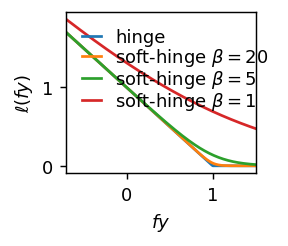

In [35]:
fig, ax1 = plt.subplots(1, 1, figsize=(2.3, 2), dpi=130)


plt.sca(ax1)
x = torch.linspace(-0.7, 1.5, 200)
plt.plot(x, x.neg().add(1).relu(), label='hinge')
plt.plot(x, torch.nn.functional.softplus(x.neg().add(1), beta=20), label=r'soft-hinge $\beta=20$')
plt.plot(x, torch.nn.functional.softplus(x.neg().add(1), beta=5), label=r'soft-hinge $\beta=5$')
plt.plot(x, torch.nn.functional.softplus(x.neg().add(1), beta=1), label=r'soft-hinge $\beta=1$')

plt.legend(handlelength=1, labelspacing=0, frameon=False)
plt.xlabel(r'$fy$')
plt.ylabel(r'$\ell(fy)$')
plt.xlim(min(x), max(x))

plt.tight_layout()
plt.savefig('loss.pdf')

# Disentangling feature learning versus lazy learning from performance

In [37]:
load("F10k3Lsp_alpha")
load("F10k3Lsp_adam")

[]

`python -m grid F10k3Lsp_h_init --n 20 "srun --partition gpu --qos gpu --gres gpu:1 --time 09:00:00 --mem 12G python main.py --data_seed 0 --batch_seed 0 --init_kernel 1 --regular 0 --final_kernel 0 --pte 50000 --arch fc_softplus --L 3 --spbeta 5 --train_time 18000 --ptr 10000 --max_dout 0.1 --dataset fashion --max_dgrad 1e-4 --lossbeta 20" --init_seed 0 1 2 3 4 5 6 7 8 9 --alpha 1 --h:int 10 14 19 27 37 52 72 100 139 193 268 373 518 720 1000 1390`

<br>

`pythonpython -m grid F10k3Lsp_h --n 20 "srun --partition gpu --qos gpu --gres gpu:1 --time 09:00:00 --mem 12G python main.py --data_seed 0 --batch_seed 0 --init_kernel 0 --regular 1 --final_kernel 0 --pte 50000 --arch fc_softplus --L 3 --spbeta 5 --train_time 18000 --ptr 10000 --max_dout 0.1 --dataset fashion --max_dgrad 1e-4 --lossbeta 20" --init_seed 0 1 2 3 4 5 6 7 8 9 --alpha 1e-4 1e-2 1e0 1e2 1e4 --h:int 10 14 19 27 37 52 72 100 139 193 268 373 518 720 1000 1390`

`python -m grid F10k3Lsp_alpha --n 20 "srun --partition gpu --qos gpu --gres gpu:1 --time 09:00:00 --mem 12G python main.py --data_seed 0 --batch_seed 0 --init_kernel 1 --final_kernel 1 --delta_kernel 1 --pte 50000 --arch fc_softplus --L 3 --spbeta 5 --train_time 18000 --ptr 10000 --max_dout 0.1 --dataset fashion --lossbeta 20 --max_dgrad 1e-4" --init_seed 0 1 2 3 4 5 6 7 8 9 --alpha 1e-4 3.2e-4 1e-3 3.2e-3 1e-2 3.2e-2 1e-1 3.2e-1 1e0 3.2e0 1e1 3.2e1 1e2 3.2e2 1e3 3.2e3 1e4 3.2e4 1e5 3.2e5 1e6 3.2e6 1e7 --h:int 100 300 1000`

NotADirectoryError: F10k3Lsp_h_init does not exists

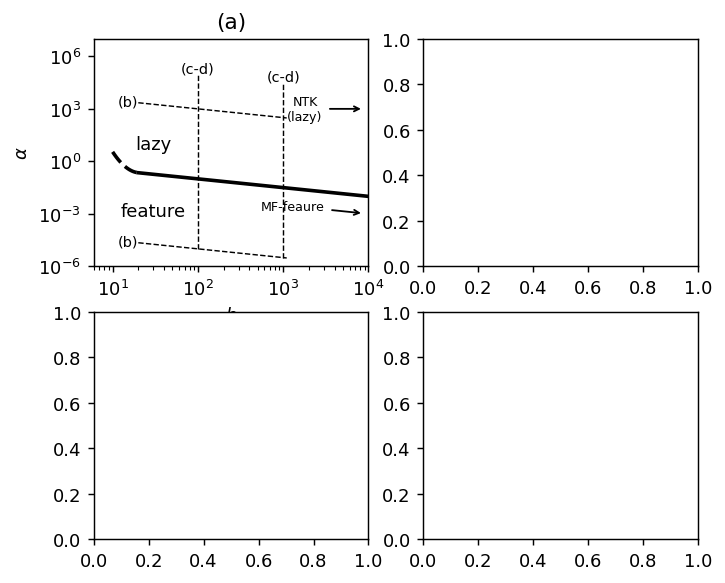

In [38]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(6, 5), dpi=130)



plt.sca(ax1)
x1, x2 = 20, 10000
y1, y2 = 20 ** -0.5, 10000 ** -0.5
plt.plot([x1, x2], [y1, y2], 'k', linewidth=2)
x = torch.linspace(10, 20, 20)
plt.plot(x, torch.exp(5*(x.log() - math.log(x1)) ** 2 + (math.log(y2)-math.log(y1))/(math.log(x2)-math.log(x1)) * (x.log()-math.log(x1)) + math.log(y1)), 'k--', linewidth=2)

plt.xscale('log')
plt.yscale('log')

plt.xlim(6, 10000)
plt.ylim(1e-6, 1e7)

plt.annotate(r"feature", (3e1, 1.5e-3), horizontalalignment='center', verticalalignment='center')
plt.annotate(r"lazy", (3e1, 1e1), horizontalalignment='center', verticalalignment='center')

plt.annotate("NTK\n(lazy)", xy=(9e3, 1e3), xytext=(1.8e3, 1e3), fontsize=7, arrowprops=dict(arrowstyle="->"), horizontalalignment='center', verticalalignment='center')
# plt.annotate("MF-lazy", xy=(9e3, 10 * 9e3 ** -0.5), xytext=(15e2, 10 * 15e2 ** -0.5), fontsize=7, arrowprops=dict(arrowstyle="->"), horizontalalignment='center', verticalalignment='center')
plt.annotate("MF-feaure", xy=(9e3, 0.1 * 9e3 ** -0.5), xytext=(13e2, 0.1 * 13e2 ** -0.5), fontsize=7, arrowprops=dict(arrowstyle="->"), horizontalalignment='center', verticalalignment='center')

plt.plot([20, 1100], [1e-4 * 20 ** -0.5, 1e-4 * 1100 ** -0.5], '--k', linewidth=0.8)
plt.plot([20, 1100], [1e4 * 20 ** -0.5, 1e4 * 1100 ** -0.5], '--k', linewidth=0.8)
plt.plot([100, 100], [1e-4 * 100 ** -0.5, 1e6 * 100 ** -0.5], '--k', linewidth=0.8)
plt.plot([1000, 1000], [1e-4 * 1000 ** -0.5, 1e6 * 1000 ** -0.5], '--k', linewidth=0.8)
plt.annotate(r"(b)", (1.5e1, 2.5e3), fontsize=8, horizontalalignment='center', verticalalignment='center')
plt.annotate(r"(b)", (1.5e1, 2.5e-5), fontsize=8, horizontalalignment='center', verticalalignment='center')
plt.annotate(r"(c-d)", (1e2, 2e5), fontsize=8, horizontalalignment='center', verticalalignment='center')
plt.annotate(r"(c-d)", (1e3, 7e4), fontsize=8, horizontalalignment='center', verticalalignment='center')

plt.xlabel(r'$h$')
plt.ylabel(r'$\alpha$')
plt.title('(a)')



plt.sca(ax2)
runs = load("F10k3Lsp_h_init")
runs = [r for r in runs if 'init_kernel' in r]
runs = [r for r in runs if r['args'].tau_over_h == 0]
runs = [r for r in runs if nd(r['init_kernel']['train'], r['args'].alpha) == 0]

hs = sorted({r['args'].h for r in runs})
vs = [mean(err(r['init_kernel']['test']) for r in runs if r['args'].h == h) for h in hs]
plt.plot(hs, vs, label=r'init. ker.', color='k')

runs = load("F10k3Lsp_h", predicate=lambda args: args.alpha in [1e-4, 1e-2, 1e0, 1e4])
runs = [r for r in runs if 'regular' in r]
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]

for a in sorted({r['args'].alpha for r in runs}, reverse=True):
    rs = [r for r in runs if r['args'].alpha == a]

    hs = sorted({r['args'].h for r in rs})
    vs = [mean(err(r['regular']['test']) for r in rs if r['args'].h == h) for h in hs]
    plt.plot(hs, vs, label=r'$\sqrt{{h}} \alpha = {}$'.format(texnum(a)))


plt.yticks([0, 0.01, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045], ['0', '1%', '2%', '2.5%', '3%', '3.5%', '4%', '4.5%'])
plt.xscale('log')
plt.legend(labelspacing=0, frameon=False)
plt.xlabel('$h$')
plt.ylabel('test error')
plt.ylim(0.025, 0.05)
plt.xlim(10, 1390)
plt.title('(b)')



plt.sca(ax3)
runs = load("F10k3Lsp_alpha")
runs = [r for r in runs if r['args'].tau_over_h == 0]
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]
hs = sorted({r['args'].h for r in runs})

for h in hs:
    rs = [r for r in runs if r['args'].h == h]
    als = sorted({r['args'].alpha for r in rs})

    xs = [a / h**0.5 for a in als]
    vs = [mean(err(r['regular']['test']) for r in rs if r['args'].alpha == a) for a in als]
    plt.plot(xs, vs, label=r'$h = {}$'.format(h))

plt.xscale('log')
plt.legend(labelspacing=0, frameon=False)
plt.xlabel(r'$\alpha$')
plt.ylabel('test error')
plt.yticks([0, 0.01, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045], ['0', '1%', '2%', '2.5%', '3%', '3.5%', '4%', '4.5%'])
plt.xlim(4e-6, 1e6)
plt.ylim(0.025, 0.035)
plt.title('(c)')



plt.sca(ax4)
runs = load("F10k3Lsp_alpha")
runs = [r for r in runs if r['args'].tau_over_h == 0]
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]
hs = sorted({r['args'].h for r in runs})

for h in hs:
    rs = [r for r in runs if r['args'].h == h]
    als = sorted({r['args'].alpha for r in rs})
    als = [a for a in als if a > 1e-1]

    vs = [mean(err(r['regular']['test']) for r in rs if r['args'].alpha == a) for a in als]
    m1 = min(vs)
    m2 = max(vs)
    vs = [(x - m1) / (m2 - m1) for x in vs]
    plt.plot(als, vs, label=r'$h = {}$'.format(h))

plt.xscale('log')
plt.legend(labelspacing=0, frameon=False)
plt.xlabel(r'$\sqrt{h} \alpha$')
plt.ylabel('rescaled test error')
plt.xlim(min(als), max(als))
plt.title('(d)')

plt.tight_layout()
plt.savefig('test_error.pgf')

# Fluctuations of output function and effect of ensemble averaging


python -m grid F1k3Lsp_h --n 20 "srun --partition gpu --qos gpu --gres gpu:1 --time 09:00:00 --mem 12G python main.py --data_seed 0 --batch_seed 0 --init_kernel 0 --regular 1 --final_kernel 0 --pte 50000 --arch fc_softplus --L 3 --spbeta 5 --train_time 18000 --ptr 1000 --max_dout 0.1 --dataset fashion --max_dgrad 1e-4 --lossbeta 20" --init_seed 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 --alpha 1e-4 1e-2 1e0 1e2 1e4 --h:int 27 37 52 72 100 139 193 268 373 518 720 1000 1390 1930 2680 3720 5170

NotADirectoryError: F1k3Lsp_h does not exists

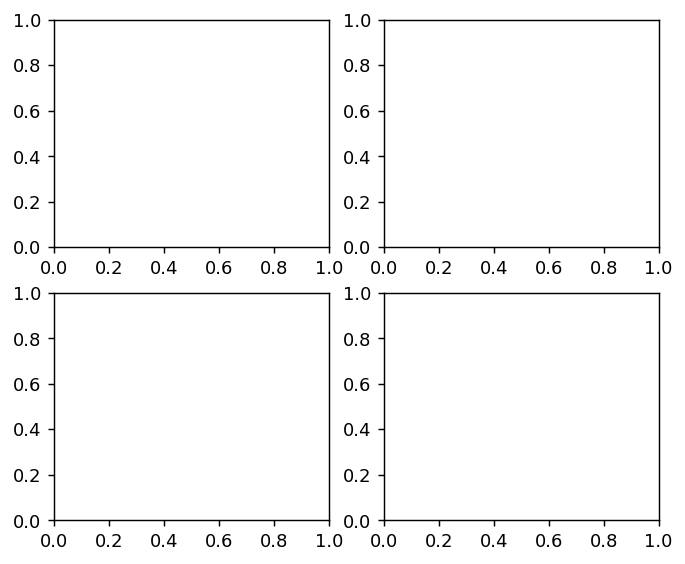

In [39]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(6, 5), dpi=130)


plt.sca(ax1)
runs = load("F1k3Lsp_h")
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]

als = sorted({r['args'].alpha for r in runs})
als = [a for a in als if a > 1e-4]

print()
for a in reversed(als):
    rs = [r for r in runs if r['args'].alpha == a]
    hs = sorted({r['args'].h for r in rs})
    print([len([1 for r in rs if r['args'].h == h]) for h in hs])
    n = 20
    print(n)
    assert n in [len([1 for r in rs if r['args'].h == h]) for h in hs]
    rs = [r for rs in [[r for r in rs if r['args'].h == h] for h in hs] if len(rs) >= n for r in rs[:n]]
    hs = sorted({r['args'].h for r in rs})
    vs = [var([r['regular']['test']['outputs'] for r in rs if r['args'].h == h], a) for h in hs]
    [line, _, _] = plt.errorbar(hs, vs, fmt='.')
    plt.plot([], [], label=r'$\sqrt{{h}}\alpha = {}$'.format(texnum(a)), color=line.get_color())

plt.xlim(27, 5170)
plt.yscale('log')
plt.xscale('log')
plt.legend(labelspacing=0, frameon=False)
plt.ylabel(r'$\mathrm{Var}[ \alpha(f(w) - f(w_0)) ]$')
plt.xlabel(r'$h$')
plt.title('(a)')
triangle(1e3, 5e3, 1e-1, slope=-1, fmt="-1", other=True)
triangle(1e3, 5e3, 1e-2, slope=-1, fmt="")




plt.sca(ax2)
runs = load("F10k3Lsp_alpha")
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]

hs = sorted({r['args'].h for r in runs})

print()
for h in hs:
    rs = [r for r in runs if r['args'].h == h]
    als = sorted({r['args'].alpha for r in rs})
    print([len([1 for r in rs if r['args'].alpha == a]) for a in als])
    n = 10
    print(n)
    assert n in [len([1 for r in rs if r['args'].alpha == a]) for a in als]
    rs = [r for rs in [[r for r in rs if r['args'].alpha == a] for a in als] if len(rs) >= n for r in rs[:n]]
    als = sorted({r['args'].alpha for r in rs})

    ws = [a for a in als]
    vs = [h * var([r['regular']['test']['outputs'] for r in rs if r['args'].alpha == a], a) for a in als]
    plt.plot(ws, vs, label=r'$h = {}$'.format(h))

plt.xscale('log')
plt.legend(frameon=False, labelspacing=0)
plt.xlabel(r'$\sqrt{h}\alpha$')
plt.ylabel(r'$h \cdot \mathrm{Var}[ \alpha(f(w) - f(w_0)) ]$')
plt.xlim(1e-4, 1e7)
plt.title('(b)')




plt.sca(ax3)
runs = load("F10k3Lsp_alpha")
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]
hs = sorted({r['args'].h for r in runs})

print()
for h in hs:
    rs = [r for r in runs if r['args'].h == h]
    als = sorted({r['args'].alpha for r in rs})
    print([len([1 for r in rs if r['args'].alpha == a]) for a in als])
    n = 10
    print(n)
    assert n in [len([1 for r in rs if r['args'].alpha == a]) for a in als]
    rs = [r for rs in [[r for r in rs if r['args'].alpha == a] for a in als] if len(rs) >= n for r in rs[:n]]
    als = sorted({r['args'].alpha for r in rs})

    ws = [a for a in als]
    vs = [mean(err(r['regular']['test']) for r in rs if r['args'].alpha == a) for a in als]
    [line] = plt.plot(ws, vs, label=r'$h = {}$'.format(h))

    vs = [enserr([r['regular']['test'] for r in rs if r['args'].alpha == a]) for a in als]
    plt.plot(ws, vs, '--', color=line.get_color())

plt.xscale('log')
from matplotlib.lines import Line2D
lines, texts = plt.gca().get_legend_handles_labels()
lines += [Line2D([0], [0], color='k', linestyle='--')]
texts += ['ensemble']
plt.legend(lines, texts, frameon=False, labelspacing=0)
plt.xlabel(r'$\sqrt{h}\alpha$')
plt.ylabel('test error')
plt.xlim(1e-4, 1e7)
y = [2, 2.5, 3, 3.5]
plt.yticks([y / 100 for y in y], [r'${:.1f}\%$'.format(y) for y in y])
plt.title('(c)')





plt.sca(ax4)
runs = load("F10k3Lsp_h", predicate=lambda args: args.alpha in [1e-4, 1e-2, 1e0, 1e4])
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]

als = sorted({r['args'].alpha for r in runs})
als = [a for a in als if a > 1e-4]

print()
for a in reversed(als):
    rs = [r for r in runs if r['args'].alpha == a]
    hs = sorted({r['args'].h for r in rs})
    print([len([1 for r in rs if r['args'].h == h]) for h in hs])
    n = 10
    print(n)
    assert n in [len([1 for r in rs if r['args'].h == h]) for h in hs]
    rs = [r for rs in [[r for r in rs if r['args'].h == h] for h in hs] if len(rs) >= n for r in rs[:n]]
    hs = sorted({r['args'].h for r in rs})

    vs = [mean([err(r['regular']['test']) for r in rs if r['args'].h == h]) for h in hs]
    [line] = plt.plot(hs, vs, label=r'$\sqrt{{h}} \alpha = {}$'.format(texnum(a)))

    vs = [enserr([r['regular']['test'] for r in rs if r['args'].h == h]) for h in hs]
    plt.plot(hs, vs, '--', color=line.get_color())

plt.xlim(10, 1390)
plt.xscale('log')
from matplotlib.lines import Line2D
lines, texts = plt.gca().get_legend_handles_labels()
lines += [Line2D([0], [0], color='k', linestyle='--')]
texts += ['ensemble']
plt.legend(lines, texts, frameon=False, labelspacing=0)
y = [2, 3, 4, 5]
plt.yticks([y / 100 for y in y], [r'${}\%$'.format(y) for y in y])
plt.ylim(2.2e-2, 4.5e-2)
plt.ylabel(r'test error')
plt.xlabel(r'$h$')
plt.title('(d)')



plt.tight_layout()
plt.savefig('var_ens.pgf')

In [40]:
runs = load("F10k3Lsp_h", predicate=lambda args: args.alpha in [1e4, 1e6])
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]
als = sorted({r['args'].alpha for r in runs})

for a in reversed(als):
    rs = [r for r in runs if r['args'].alpha == a]
    hs = sorted({r['args'].h for r in rs})

    vs = [mean(r['regular']['dynamics'][-1]['wall'] / 60 for r in rs if r['args'].h == h) for h in hs]
    plt.plot(hs, vs, label=r'$\sqrt{{h}} \alpha = {}$'.format(texnum(a)))

plt.xlim(10, 1390)
plt.xscale('log')
plt.legend(frameon=False, labelspacing=0)
plt.ylabel(r'wall')
plt.xlabel(r'$h$')

TypeError: load() got an unexpected keyword argument 'predicate'

# MNIST


python -m grid M10k3Lsp_alpha --n 20 "srun --nice --partition gpu --qos gpu --gres gpu:1 --time 09:00:00 --mem 12G python main.py --data_seed 0 --batch_seed 0 --init_kernel 1 --final_kernel 1 --delta_kernel 1 --pte 50000 --arch fc_softplus --L 3 --spbeta 5 --train_time 18000 --ptr 10000 --max_dout 0.1 --dataset mnist --lossbeta 20 --max_dgrad 1e-4" --init_seed 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 --alpha 1e-4 3.2e-4 1e-3 3.2e-3 1e-2 3.2e-2 1e-1 3.2e-1 1e0 3.2e0 1e1 3.2e1 1e2 3.2e2 1e3 3.2e3 1e4 3.2e4 1e5 3.2e5 1e6 3.2e6 1e7 --h:int 100 300 1000

python -m grid C10k3Lsp_alpha --n 20 "srun --partition gpu --qos gpu --gres gpu:1 --time 09:00:00 --mem 12G python main.py --data_seed 0 --batch_seed 0 --init_kernel 1 --final_kernel 1 --delta_kernel 1 --pte 50000 --arch fc_softplus --L 3 --spbeta 5 --train_time 18000 --ptr 10000 --max_dout 0.1 --dataset cifar10 --lossbeta 20 --max_dgrad 1e-4" --init_seed 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 --alpha 1e-4 1e-3 1e-2 1e-1 1e0 1e1 1e2 1e3 1e4 1e5 1e6 1e7 --h:int 100


python -m grid C10k3Lsp_adam --n 32 "srun --partition gpu --qos gpu --gres gpu:1 --time 09:00:00 --mem 12G python main_adam.py --data_seed 0 --batch_seed 0 --dataset cifar10 --ptr 10000 --pte 50000 --arch fc_softplus --L 3 --spbeta 5 --bs 32 --lr 1e-3 --train_time 28800.0 --loss hinge" --h:int 100 --init_seed:int 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 --alpha:float 1e-3 1e-2 1e-1 1e0 1e1 1e2 1e3 1e4 1e5 1e6 1e7

NotADirectoryError: M10k3Lsp_alpha does not exists

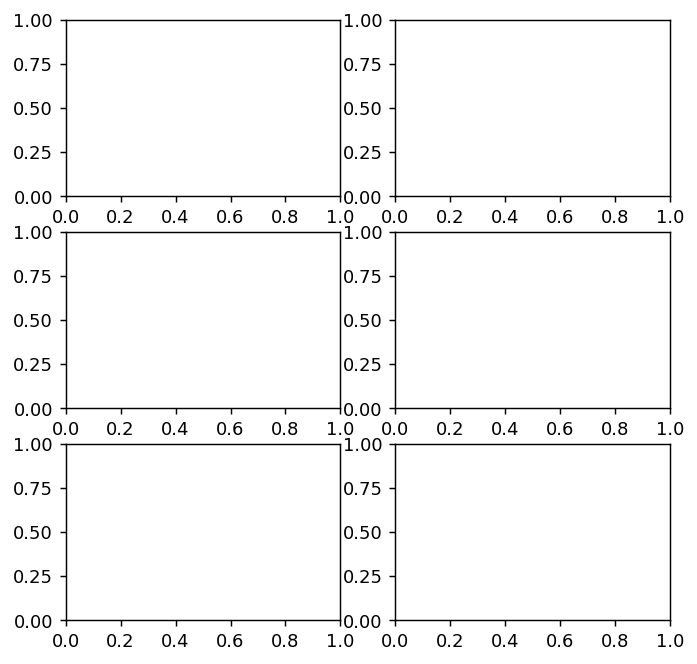

In [41]:
fig, [[ax1, ax2], [ax3, ax4], [ax5, ax6]] = plt.subplots(3, 2, figsize=(6, 6), dpi=130)


plt.sca(ax1)
runs = load("M10k3Lsp_alpha")
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]
hs = sorted({r['args'].h for r in runs})

print(1)
for h in hs:
    rs = [r for r in runs if r['args'].h == h]
    als = sorted({r['args'].alpha for r in rs})
    print([len([1 for r in rs if r['args'].alpha == a]) for a in als])
    n = 20
    print(n)
    #assert n in [len([1 for r in rs if r['args'].alpha == a]) for a in als]
    rs = [r for rs in [[r for r in rs if r['args'].alpha == a] for a in als] if len(rs) >= n for r in rs[:n]]
    als = sorted({r['args'].alpha for r in rs})

    ws = [a for a in als]
    vs = [mean(err(r['regular']['test']) for r in rs if r['args'].alpha == a) for a in als]
    [line] = plt.plot(ws, vs, label=r'$h = {}$'.format(h))

    vs = [enserr([r['regular']['test'] for r in rs if r['args'].alpha == a]) for a in als]
    plt.plot(ws, vs, '--', color=line.get_color())

plt.xscale('log')
from matplotlib.lines import Line2D
lines, texts = plt.gca().get_legend_handles_labels()
lines += [Line2D([0], [0], color='k', linestyle='--')]
texts += ['ensemble']
plt.legend(lines, texts, frameon=False, labelspacing=0)
plt.xlabel(r'$\sqrt{h}\alpha$')
plt.ylabel('test error')
plt.xlim(1e-4, 1e7)
plt.gca().yaxis.set_major_formatter(format_percent)
plt.title('(a)')





plt.sca(ax2)
runs = load("M10k3Lsp_h_init")
runs = [r for r in runs if 'init_kernel' in r]
runs = [r for r in runs if nd(r['init_kernel']['train'], r['args'].alpha) == 0]

hs = sorted({r['args'].h for r in runs})
vs = [mean(err(r['init_kernel']['test']) for r in runs if r['args'].h == h) for h in hs]
plt.plot(hs, vs, 'k-', label=r'init. ker.')

vs = [enserr([r['init_kernel']['test'] for r in runs if r['args'].h == h]) for h in hs]
plt.plot(hs, vs, 'k--')

runs = load("M10k3Lsp_h", predicate=lambda args: args.alpha in [1e-4, 1e-2, 1e0, 1e4])
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]

als = sorted({r['args'].alpha for r in runs})
als = [a for a in als if a > 1e-4]

print(2)
for a in reversed(als):
    rs = [r for r in runs if r['args'].alpha == a]
    hs = sorted({r['args'].h for r in rs})
    print([len([1 for r in rs if r['args'].h == h]) for h in hs])
    n = 10
    print(n)
    assert n in [len([1 for r in rs if r['args'].h == h]) for h in hs]
    rs = [r for rs in [[r for r in rs if r['args'].h == h] for h in hs] if len(rs) >= n for r in rs[:n]]
    hs = sorted({r['args'].h for r in rs})

    vs = [mean([err(r['regular']['test']) for r in rs if r['args'].h == h]) for h in hs]
    [line] = plt.plot(hs, vs, label=r'$\sqrt{{h}} \alpha = {}$'.format(texnum(a)))

    vs = [enserr([r['regular']['test'] for r in rs if r['args'].h == h]) for h in hs]
    plt.plot(hs, vs, '--', color=line.get_color())

from matplotlib.lines import Line2D
lines, texts = plt.gca().get_legend_handles_labels()
lines += [Line2D([0], [0], color='k', linestyle='--')]
texts += ['ensemble']
plt.legend(lines, texts, frameon=False, labelspacing=0)

plt.xlim(10, 1390)
plt.xscale('log')
plt.gca().yaxis.set_major_formatter(format_percent)
plt.ylim(None, 8e-2)
plt.ylabel(r'test error')
plt.xlabel(r'$h$')
plt.title('(b)')




plt.sca(ax3)
runs = load("M10k3Lsp_alpha")
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]
hs = sorted({r['args'].h for r in runs})

for h in hs:
    rs = [r for r in runs if r['args'].h == h]
    als = sorted({r['args'].alpha for r in rs})
    als = [a for a in als if a > 1e-1]

    vs = [mean(err(r['regular']['test']) for r in rs if r['args'].alpha == a) for a in als]
    m1 = min(vs)
    m2 = max(vs)
    vs = [(x - m1) / (m2 - m1) for x in vs]
    plt.plot(als, vs, label=r'$h = {}$'.format(h))

plt.xscale('log')
plt.legend(labelspacing=0, frameon=False)
plt.xlabel(r'$\sqrt{h} \alpha$')
plt.ylabel('rescaled test error')
plt.xlim(min(als), max(als))
plt.title('(c)')



plt.sca(ax4)
runs = load("M10k3Lsp_alpha")
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]

hs = sorted({r['args'].h for r in runs})

print(4)
for h in hs:
    rs = [r for r in runs if r['args'].h == h]
    als = sorted({r['args'].alpha for r in rs})
    print([len([1 for r in rs if r['args'].alpha == a]) for a in als])
    n = 20
    print(n)
    assert n in [len([1 for r in rs if r['args'].alpha == a]) for a in als]
    rs = [r for rs in [[r for r in rs if r['args'].alpha == a] for a in als] if len(rs) >= n for r in rs[:n]]
    als = sorted({r['args'].alpha for r in rs})

    ws = [a for a in als]
    vs = [h * var([r['regular']['test']['outputs'] for r in rs if r['args'].alpha == a], a) for a in als]
    plt.plot(ws, vs, label=r'$h = {}$'.format(h))

plt.xscale('log')
plt.legend(frameon=False, labelspacing=0)
plt.xlabel(r'$\sqrt{h}\alpha$')
plt.ylabel(r'$h \cdot \mathrm{Var}[ \alpha(f(w) - f(w_0)) ]$')
plt.xlim(1e-4, 1e7)
plt.title('(d)')





plt.sca(ax5)
runs = load("C10k3Lsp_alpha") + load("C10k3Lsp_adam")
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]

n = 20
hs = sorted({r['args'].h for r in runs})
assert hs == [100]

algos = sorted({hasattr(r['args'], "lr") for r in runs})

print(1)
for al in algos:
    rs = [r for r in runs if hasattr(r['args'], "lr") == al]
    als = sorted({r['args'].alpha for r in rs})
    print([len([1 for r in rs if r['args'].alpha == a]) for a in als])
    print(n)
    #assert n in [len([1 for r in rs if r['args'].alpha == a]) for a in als]
    rs = [r for rs in [[r for r in rs if r['args'].alpha == a] for a in als] if len(rs) >= n for r in rs[:n]]
    als = sorted({r['args'].alpha for r in rs})

    label = "ADAM" if al else "gradient-flow"

    ws = [a for a in als]
    vs = [mean(err(r['regular']['test']) for r in rs if r['args'].alpha == a) for a in als]
    [line] = plt.plot(ws, vs, label=label)

    vs = [enserr([r['regular']['test'] for r in rs if r['args'].alpha == a]) for a in als]
    plt.plot(ws, vs, '--', color=line.get_color())

plt.xscale('log')
from matplotlib.lines import Line2D
lines, texts = plt.gca().get_legend_handles_labels()
lines += [Line2D([0], [0], color='k', linestyle='--')]
texts += ['ensemble']
plt.legend(lines, texts, frameon=False, labelspacing=0)
plt.xlabel(r'$\sqrt{h}\alpha$')
plt.ylabel('test error')
plt.xlim(1e-4, 1e7)
plt.gca().yaxis.set_major_formatter(format_percent)
plt.title('(e)')



plt.sca(ax6)

print(4)
for al in algos:
    rs = [r for r in runs if hasattr(r['args'], "lr") == al]
    als = sorted({r['args'].alpha for r in rs})
    print([len([1 for r in rs if r['args'].alpha == a]) for a in als])
    print(n)
    #assert n in [len([1 for r in rs if r['args'].alpha == a]) for a in als]
    rs = [r for rs in [[r for r in rs if r['args'].alpha == a] for a in als] if len(rs) >= n for r in rs[:n]]
    als = sorted({r['args'].alpha for r in rs})

    ws = [a for a in als]
    vs = [h * var([r['regular']['test']['outputs'] for r in rs if r['args'].alpha == a], a) for a in als]
    plt.plot(ws, vs, label=r'$h = {}$'.format(h))

plt.xscale('log')
plt.yscale('log')
# plt.legend(frameon=False, labelspacing=0)
plt.xlabel(r'$\sqrt{h}\alpha$')
plt.ylabel(r'$h \cdot \mathrm{Var}[ \alpha(f(w) - f(w_0)) ]$')
plt.xlim(1e-4, 1e7)
plt.title('(f)')
plt.ylim(None, 1e7)


plt.tight_layout()
plt.savefig('mnist_cifar.pgf')

In [42]:
runs = load("C10k3Lsp_adam")
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]
sorted({r['args'].alpha for r in runs})

NotADirectoryError: C10k3Lsp_adam does not exists

# Bias

python -m grid F10k3Lsp_alpha_bias01 --n 32 "srun --nice --partition gpu --qos gpu --gres gpu:1 --time 09:00:00 --mem 12G python main.py --data_seed 0 --batch_seed 0 --init_kernel 0 --final_kernel 0 --delta_kernel 0 --pte 50000 --arch fc_softplus --L 3 --spbeta 5 --train_time 18000 --ptr 10000 --max_dout 0.1 --dataset fashion --lossbeta 20 --max_dgrad 1e-4 --bias 0.1" --init_seed 0 1 2 3 4 5 6 7 8 9 --alpha 1e-4 1e-3 1e-2 3.2e-2 1e-1 3.2e-1 1e0 3.2e0 1e1 3.2e1 1e2 1e3 1e4 1e5 1e6 1e7 --h:int 100

TypeError: load() got an unexpected keyword argument 'predicate'

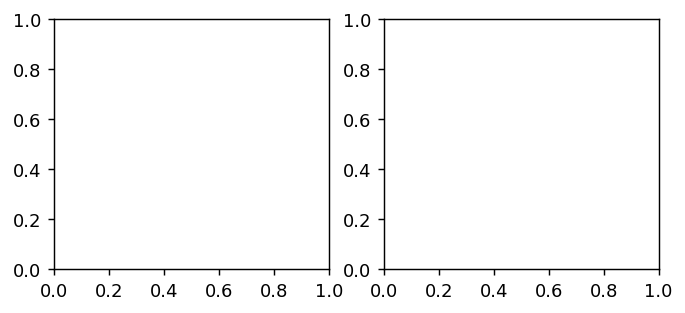

In [43]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(6, 2.5), dpi=130)

runs = load("F10k3Lsp_alpha_bias01", predicate=lambda args: args.h == 100)
runs += load("F10k3Lsp_alpha", predicate=lambda args: args.h == 100)
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]
bs = sorted({r['args'].bias for r in runs})


plt.sca(ax1)

for b in bs:
    rs = [r for r in runs if r['args'].bias == b]
    als = sorted({r['args'].alpha for r in rs})
    print([len([1 for r in rs if r['args'].alpha == a]) for a in als])
    n = 10
    print(n)
    rs = [r for rs in [[r for r in rs if r['args'].alpha == a] for a in als] if len(rs) >= n for r in rs[:n]]
    als = sorted({r['args'].alpha for r in rs})

    vs = [mean(err(r['regular']['test']) for r in rs if r['args'].alpha == a) for a in als]
    [line] = plt.plot(als, vs, label=r'with bias' if b else 'no bias')

    vs = [enserr([r['regular']['test'] for r in rs if r['args'].alpha == a]) for a in als]
    plt.plot(als, vs, '--', color=line.get_color())

plt.xscale('log')
from matplotlib.lines import Line2D
lines, texts = plt.gca().get_legend_handles_labels()
lines += [Line2D([0], [0], color='k', linestyle='--')]
texts += ['ensemble']
plt.legend(lines, texts, frameon=False, labelspacing=0)
plt.xlabel(r'$\sqrt{h}\alpha$')
plt.ylabel('test error')
plt.xlim(1e-4, 1e7)
plt.gca().yaxis.set_major_formatter(format_percent)
plt.title('(a)')



plt.sca(ax2)
for b in bs:
    rs = [r for r in runs if r['args'].bias == b]
    als = sorted({r['args'].alpha for r in rs})
    print([len([1 for r in rs if r['args'].alpha == a]) for a in als])
    n = 10
    print(n)
    rs = [r for rs in [[r for r in rs if r['args'].alpha == a] for a in als] if len(rs) >= n for r in rs[:n]]
    als = sorted({r['args'].alpha for r in rs})

    vs = [h * var([r['regular']['test']['outputs'] for r in rs if r['args'].alpha == a], a) for a in als]
    plt.plot(als, vs, label=r'$h = {}$'.format(h))

plt.xscale('log')
plt.xlabel(r'$\sqrt{h}\alpha$')
plt.ylabel(r'$h \cdot \mathrm{Var}[ \alpha(f(w) - f(w_0)) ]$')
plt.xlim(1e-4, 1e7)
plt.title('(b)')


plt.tight_layout()
plt.savefig('bias.pgf')

In [44]:
runs = load("M10k10d3Lsp_alpha", predicate=lambda args: args.h == 100)
hs = sorted({r['args'].h for r in runs})

for h in hs:
    rs = [r for r in runs if r['args'].h == h]
    als = sorted({r['args'].alpha for r in rs})

    vs = [mean(r['regular']['dynamics'][-1]['wall'] / 60 for r in rs if r['args'].alpha == a) for a in als]
    [line] = plt.plot(als, vs, '.-', label=r'$h = {}$'.format(h))

plt.xscale('log')

TypeError: load() got an unexpected keyword argument 'predicate'

NotADirectoryError: F10k3Lsp_alpha_af does not exists

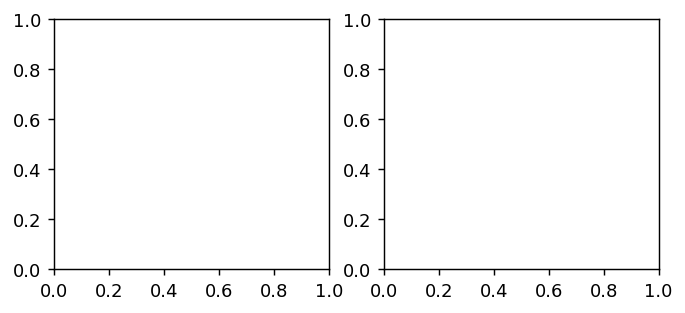

In [45]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(6, 2.5), dpi=130)

runs = load("F10k3Lsp_alpha_af")
runs += load("F10k3Lsp_alpha", predicate=lambda args: args.h in [100, 1000])
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]

def foo(r):
    h = r['args'].h
    f0 = r['args'].f0 if hasattr(r['args'], 'f0') else 1
    return h, f0

bs = sorted({foo(r) for r in runs})


plt.sca(ax1)

for b in bs:
    label = r'$h={}$'.format(b[0])
    label += r' $F = f-f_0$' if b[1] else r' $F=f$'
    rs = [r for r in runs if foo(r) == b]
    als = sorted({r['args'].alpha for r in rs})
    print([len([1 for r in rs if r['args'].alpha == a]) for a in als])
    n = 10
    print(n)
    rs = [r for rs in [[r for r in rs if r['args'].alpha == a] for a in als] if len(rs) >= n for r in rs[:n]]
    als = sorted({r['args'].alpha for r in rs})
    ws = [a / b[0]**0.5 for a in als]

    vs = [mean(err(r['regular']['test']) for r in rs if r['args'].alpha == a) for a in als]
    [line] = plt.plot(ws, vs, label=label)

    vs = [enserr([r['regular']['test'] for r in rs if r['args'].alpha == a]) for a in als]
    plt.plot(ws, vs, '--', color=line.get_color())

plt.xscale('log')
from matplotlib.lines import Line2D
lines, texts = plt.gca().get_legend_handles_labels()
lines += [Line2D([0], [0], color='k', linestyle='--')]
texts += ['ensemble']
plt.legend(lines, texts, frameon=False, labelspacing=0)
plt.xlabel(r'$\alpha$')
plt.ylabel('test error')
plt.xlim(1e-6, 1e6)
plt.ylim(2.2e-2, 4e-2)
plt.gca().yaxis.set_major_formatter(format_percent)
plt.title('(a)')



plt.sca(ax2)
for b in bs:
    rs = [r for r in runs if foo(r) == b]
    als = sorted({r['args'].alpha for r in rs})
    print([len([1 for r in rs if r['args'].alpha == a]) for a in als])
    n = 10
    print(n)
    rs = [r for rs in [[r for r in rs if r['args'].alpha == a] for a in als] if len(rs) >= n for r in rs[:n]]
    als = sorted({r['args'].alpha for r in rs})
    ws = [a / b[0]**0.5 for a in als]

    h = b[0]
    vs = [h * var([r['regular']['test']['outputs'] for r in rs if r['args'].alpha == a], a) for a in als]
    plt.plot(ws, vs, label=r'$h = {}$'.format(h))

plt.xscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$h \cdot \mathrm{Var}[ \alpha F(w) ]$')
plt.xlim(1e-6, 1e6)
plt.ylim(1e1, 3e3)
plt.title('(b)')
plt.yscale('log')

plt.tight_layout()
plt.savefig('alphaf.pgf')

# Training dynamics differs in the two regimes

<ipython-input-46-fbcbc585872b>:122: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_rotation('vertical')
<ipython-input-46-fbcbc585872b>:127: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(CS3) # using the colorbar info I got from contourf


AttributeError: 'LatexManager' object has no attribute 'latex'

<Figure size 640x480 with 0 Axes>

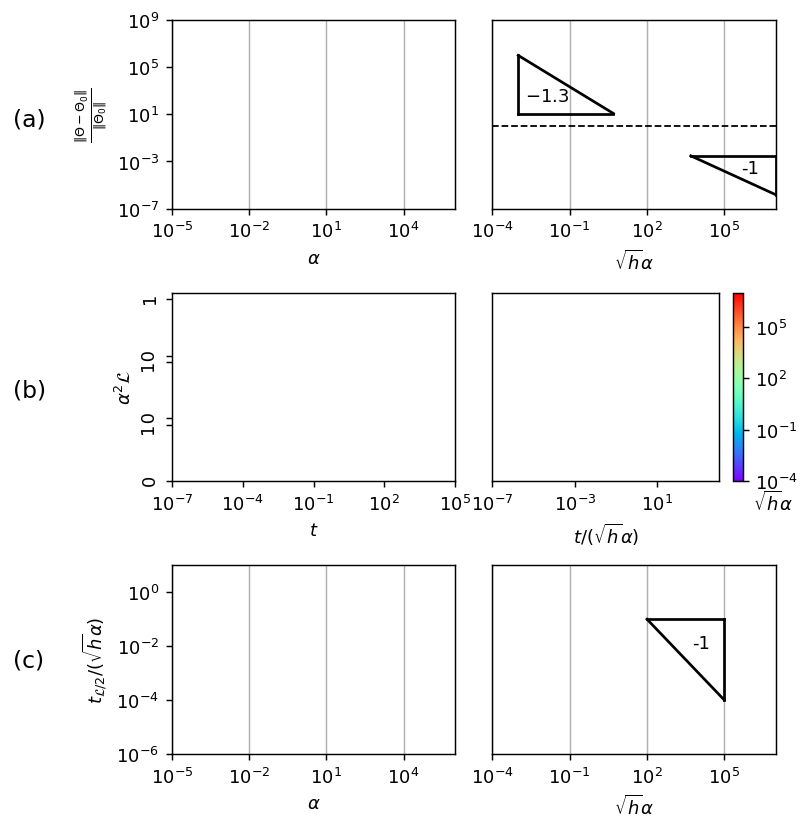

In [46]:
# Using contourf to provide my colorbar info, then clearing the figure
cmap = plt.get_cmap('rainbow')
Z = [[1,1],[1,1]]
import matplotlib.colors as colors
CS3 = plt.pcolor(Z, cmap=cmap, norm=colors.LogNorm(vmin=1e-4, vmax=1e7))
plt.clf()


runs = load("F10k3Lsp_alpha")
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0 and 'delta_kernel' in r]

fig, [[ax1, ax2], [ax3, ax4], [ax5, ax6]] = plt.subplots(3, 2, figsize=(6.5, 6.5), dpi=130)

def thth0(r):
    th0 = r['init_kernel']['kernel']['test']['norm']
    dth = r['delta_kernel']['test']
    return dth / th0

hs = sorted({r['args'].h for r in runs})

for h in hs:
    rs = [r for r in runs if r['args'].h == h]
    als = sorted({r['args'].alpha for r in rs})
    print([len([1 for r in rs if r['args'].alpha == a]) for a in als])
    n = 10
    print(n)
    rs = [r for rs in [[r for r in rs if r['args'].alpha == a] for a in als] if len(rs) >= n for r in rs[:n]]
    als = sorted({r['args'].alpha for r in rs})

    ws = [a * h ** -0.5 for a in als]

    plt.sca(ax2)
    vs = [mean(thth0(r) for r in rs if r['args'].alpha == a) for a in als]
    plt.plot(als, vs, '-', label=r'$h = {}$'.format(h))

    plt.sca(ax1)
    vs = [mean(thth0(r) for r in rs if r['args'].alpha == a) for a in als]
    plt.plot(ws, vs, '-', label=r'$h = {}$'.format(h))


# y-axis
for ax in [ax1, ax2]:
    plt.sca(ax)
    plt.yscale('log')
    plt.ylim(1e-7, 1e9)
plt.sca(ax1)
plt.ylabel(r'$\frac{\|\Theta - \Theta_0\|}{\|\Theta_0\|}$')

plt.sca(ax2)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,        # ticks along the bottom edge are off
    right=False,       # ticks along the top edge are off
    labelleft=False)   # labels along the bottom edge are off


# x-axis
plt.sca(ax1)
plt.grid(axis='x')
plt.xlim(1e-5, 1e6)
plt.xscale('log')
plt.xlabel(r'$\alpha$')

plt.sca(ax2)
plt.grid(axis='x')
plt.xlim(1e-4, 1e7)
plt.xscale('log')
plt.xlabel(r'$\sqrt{h} \alpha$')

plt.sca(ax1)
plt.legend(labelspacing=0, frameon=False)

plt.sca(ax2)
triangle(1e-3, 5e0, 1e6, slope=-4/3, fmt=r"${:.1f}$")
triangle(5e3, 1e7, 3e-3, slope=-1, other=True, fmt="-1")
plt.plot(plt.xlim(), [1, 1], '--k', linewidth=1)





##
hs = sorted({r['args'].h for r in runs})

for i, h in enumerate(hs):
    label = r"$h={}$".format(h)
    plt.sca(ax3)
    plt.annotate(label, xy=(0., i/3 + 0.1), xycoords='axes fraction')
    plt.sca(ax4)
    plt.annotate(label, xy=(1., i/3 + 0.1), xycoords='axes fraction', horizontalalignment='right')

    rs = [r for r in runs if r['args'].h == h and r['args'].init_seed < 1]

    for r in rs:
        d = r['regular']['dynamics']
        color = cmap((math.log10(r['args'].alpha) + 4) / 11)

        plt.sca(ax3)
        x = [x['t'] / r['args'].h * r['args'].alpha for x in d]
        y = [i / 3 + 0.3 * x['train']['aloss'] for x in d]
        plt.plot(x, y, linewidth=1, color=color, zorder=torch.randint(-100, 0, ()).item())

        plt.sca(ax4)
        x = [x['t'] / r['args'].h for x in d]
        y = [i / 3 + 0.3 * x['train']['aloss'] for x in d]
        plt.plot(x, y, linewidth=1, color=color, zorder=torch.randint(-100, 0, ()).item())

for ax in [ax3, ax4]:
    plt.sca(ax)
    plt.xscale('log')
    plt.yticks([])
    plt.ylim(0, 1)

plt.sca(ax3)
plt.xlabel(r'$t$')
plt.xlim(1e-7, 1e5)
plt.ylabel(r'$\alpha^2 \mathcal{L}$')
plt.yticks([i / 3 + 0.3 * loss for i in range(3) for loss in [0, 1]], ['0', '1 ', ' 0', '1 ', ' 0', '1'])
for tick in plt.gca().yaxis.get_major_ticks():
#     tick.label.set_fontsize(14)
    tick.label.set_rotation('vertical')

plt.sca(ax4)
plt.xlabel(r'$t / (\sqrt{h}\alpha)$')
plt.xlim(1e-7, 1e4)
plt.colorbar(CS3) # using the colorbar info I got from contourf
plt.annotate(r"$\sqrt{h}\alpha$", xy=(1.15, -0.15), xycoords='axes fraction')




##
hs = sorted({r['args'].h for r in runs})

for h in hs:
    rs = [r for r in runs if r['args'].h == h]
    als = sorted({r['args'].alpha for r in rs})
    print([len([1 for r in rs if r['args'].alpha == a]) for a in als])
    n = 10
    print(n)
    rs = [r for rs in [[r for r in rs if r['args'].alpha == a] for a in als] if len(rs) >= n for r in rs[:n]]
    als = sorted({r['args'].alpha for r in rs})

    ws = [a * h ** -0.5 for a in als]

    plt.sca(ax6)
    vs = [mean(
        next(x['t'] / h for x in r['regular']['dynamics'] if x['train']['aloss'] < 0.5)
        for r in rs if r['args'].alpha == a)
    for a in als]
    plt.plot(als, vs)

    plt.sca(ax5)
    vs = [mean(
        next(x['t'] / h for x in r['regular']['dynamics'] if x['train']['aloss'] < 0.5)
        for r in rs if r['args'].alpha == a)
    for a in als]
    plt.plot(ws, vs)


# y-axis
for ax in [ax5, ax6]:
    plt.sca(ax)
    plt.ylim(1e-6, 1e1)
    plt.yscale('log')
plt.sca(ax5)
plt.ylabel(r'$t_{\mathcal{L}/2} / (\sqrt{h}\alpha)$')

for ax in [ax4, ax6]:
    plt.sca(ax)
    plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,        # ticks along the bottom edge are off
        right=False,       # ticks along the top edge are off
        labelleft=False) # labels along the bottom edge are off

plt.sca(ax5)
plt.grid(axis='x')
plt.xlim(1e-5, 1e6)
plt.xscale('log')
plt.xlabel(r'$\alpha$')

plt.sca(ax6)
plt.grid(axis='x')
plt.xlim(1e-4, 1e7)
plt.xscale('log')
plt.xlabel(r'$\sqrt{h} \alpha$')

plt.sca(ax6)
triangle(1e2, 1e5, 1e-1, slope=-1, other=True, fmt="-1")

fig.text(0, 0.85, r"(a)", verticalalignment='center', horizontalalignment='left', fontsize=13)
fig.text(0, 0.53, r"(b)", verticalalignment='center', horizontalalignment='left', fontsize=13)
fig.text(0, 0.21, r"(c)", verticalalignment='center', horizontalalignment='left', fontsize=13)

plt.tight_layout(h_pad=1., w_pad=0, rect=[0.05, 0, 0.95, 1])
plt.savefig('time_dynamics.pgf')

# Other

python -m grid 10kCsp_adam --n 32 "srun --partition gpu --qos gpu --gres gpu:1 --time 09:00:00 --mem 12G python main_adam.py --data_seed 0 --batch_seed 0 --ptr 10000 --pte 50000 --arch cv_softplus --spbeta 5 --bs 32 --lr 1e-3 --train_time 28800.0 --loss hinge" --h:int 50 --init_seed:int 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 --alpha:float 1e-3 1e-2 1e-1 1e0 1e1 1e2 1e3 1e4 1e5 1e6 1e7 --dataset:str fashion cifar10

python -m grid M10k10d3Lsp_alpha --n 32 "srun --nice --partition gpu --qos gpu --gres gpu:1 --time 09:00:00 --mem 12G python main.py --data_seed 0 --batch_seed 0 --init_kernel 1 --final_kernel 1 --delta_kernel 1 --pte 50000 --arch fc_softplus --L 3 --spbeta 5 --train_time 18000 --ptr 10000 --max_dout 0.1 --dataset mnist --d 10 --lossbeta 20 --max_dgrad 1e-4" --init_seed 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 --alpha 1e-4 3.2e-4 1e-3 3.2e-3 1e-2 3.2e-2 1e-1 3.2e-1 1e0 3.2e0 1e1 3.2e1 1e2 3.2e2 1e3 3.2e3 1e4 3.2e4 1e5 3.2e5 1e6 3.2e6 1e7 --h:int 100

TypeError: load() got an unexpected keyword argument 'predicate'

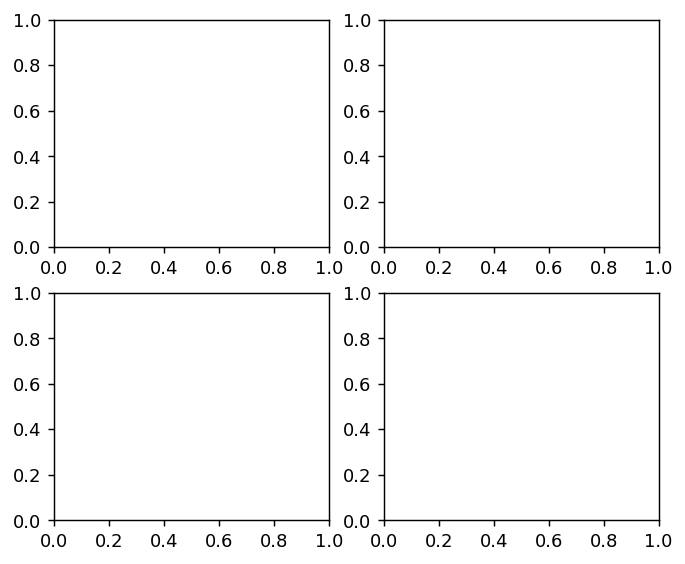

In [47]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(6, 5), dpi=130)


plt.sca(ax1)
#runs = load("nd_M10d5L5kP_alpha_sp_1", predicate=lambda args: args.h in [200, 800] and args.init_seed < 10)
runs = load("M10k10d3Lsp_alpha", predicate=lambda args: args.h == 100)
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]
hs = sorted({r['args'].h for r in runs})

for h in hs:
    rs = [r for r in runs if r['args'].h == h]
    als = sorted({r['args'].alpha for r in rs})
    print([len([1 for r in rs if r['args'].alpha == a]) for a in als])
    n = 20
    print(n)
    rs = [r for rs in [[r for r in rs if r['args'].alpha == a] for a in als] if len(rs) >= n for r in rs[:n]]
    als = sorted({r['args'].alpha for r in rs})

    ws = [a * h ** 0.5 for a in als]
    vs = [mean(err(r['regular']['test']) for r in rs if r['args'].alpha == a) for a in als]
    [line] = plt.plot(ws, vs, label=r'$h = {}$'.format(h))

    vs = [enserr([r['regular']['test'] for r in rs if r['args'].alpha == a]) for a in als]
    plt.plot(ws, vs, '--', color=line.get_color())

plt.xscale('log')
from matplotlib.lines import Line2D
lines, texts = plt.gca().get_legend_handles_labels()
lines = [Line2D([0], [0], color='k', linestyle='--')]
texts = ['ensemble']
plt.legend(lines, texts, frameon=False, labelspacing=0)
plt.xlabel(r'$\sqrt{h}\alpha$')
plt.ylabel('test error')
plt.xlim(2e-2, 1e6)
plt.gca().yaxis.set_major_formatter(format_percent)

plt.title('(a) 10PCA MNIST FC softplus')




plt.sca(ax2)
for d in ['fashion', 'cifar10']:
    label = 'Fashion-MNIST' if d == 'fashion' else 'CIFAR10'
    [line] = plt.plot([], [], label=label)
    color = line.get_color()

    if d == 'cifar10':
        plt.twinx()

    plt.gca().yaxis.set_major_formatter(format_percent)

    runs = load('10kCsp_adam', predicate=lambda args: args.h == 50 and args.dataset == d)
    runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) < 0.04 * r['args'].ptr]

    rs = runs
    als = sorted({r['args'].alpha for r in rs})
    print([len([1 for r in rs if r['args'].alpha == a]) for a in als])
    n = 16
    print(n)
    rs = [r for rs in [[r for r in rs if r['args'].alpha == a] for a in als] if len(rs) >= n for r in rs[:n]]
    als = sorted({r['args'].alpha for r in rs})

    vs = [mean(err(r['regular']['test']) for r in rs if r['args'].alpha == a) for a in als]
    plt.plot(als, vs, color=color)

    vs = [enserr([r['regular']['test'] for r in rs if r['args'].alpha == a]) for a in als]
    plt.plot(als, vs, '--', color=color)

    plt.sca(ax2)

plt.xscale('log')
from matplotlib.lines import Line2D
lines, texts = plt.gca().get_legend_handles_labels()
lines += [Line2D([0], [0], color='k', linestyle='--')]
texts += ['ensemble']
plt.legend(lines, texts, frameon=False, labelspacing=0)
plt.xlabel(r'$\sqrt{h}\alpha$')
plt.ylabel('test error')
plt.xlim(min(als), max(als))

plt.title('(b) CNN softplus hinge')




plt.sca(ax3)
runs = load('EM10k3Lsp_alpha', predicate=lambda args: args.h == 100)
runs += load('EM10k3Lsp_10beta_alpha', predicate=lambda args: args.h == 100)
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]
print_info(r['args'] for r in runs)

betas = sorted({hasattr(r['args'], 'lossbeta') for r in runs})

for beta in betas:
    rs = [r for r in runs if hasattr(r['args'], 'lossbeta') == beta]
    als = sorted({r['args'].alpha for r in rs})
    print([len([1 for r in rs if r['args'].alpha == a]) for a in als])
    n = 10
    print(n)
    rs = [r for rs in [[r for r in rs if r['args'].alpha == a] for a in als] if len(rs) >= n for r in rs[:n]]
    als = sorted({r['args'].alpha for r in rs})

    vs = [mean(err(r['regular']['test']) for r in rs if r['args'].alpha == a) for a in als]
    [line] = plt.plot(als, vs, label=r'current setup' if beta else r'$\beta=10$ and $\tau=10^{-3}t$')

    vs = [enserr([r['regular']['test'] for r in rs if r['args'].alpha == a]) for a in als]
    plt.plot(als, vs, '--', color=line.get_color())

plt.xscale('log')
from matplotlib.lines import Line2D
lines, texts = plt.gca().get_legend_handles_labels()
lines += [Line2D([0], [0], color='k', linestyle='--')]
texts += ['ensemble']
plt.legend(lines, texts, frameon=False, labelspacing=0)
plt.xlabel(r'$\sqrt{h}\alpha$')
plt.ylabel('test error')
plt.xlim(min(als), max(als))
plt.gca().yaxis.set_major_formatter(format_percent)

plt.title('(c) EMNIST FC h=100 softplus')



plt.sca(ax4)
runs = load('F10k9Lsp_alpha', predicate=lambda args: args.h == 100)
runs += load('F10k3Lsp_alpha', predicate=lambda args: args.h == 100)
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]
Ls = sorted({r['args'].L for r in runs})
print_info(r['args'] for r in runs)

for L in Ls:
    rs = [r for r in runs if r['args'].L == L]
    als = sorted({r['args'].alpha for r in rs})
    print([len([1 for r in rs if r['args'].alpha == a]) for a in als])
    n = 10
    print(n)
    rs = [r for rs in [[r for r in rs if r['args'].alpha == a] for a in als] if len(rs) >= n for r in rs[:n]]
    als = sorted({r['args'].alpha for r in rs})

    vs = [mean(err(r['regular']['test']) for r in rs if r['args'].alpha == a) for a in als]
    [line] = plt.plot(als, vs, label=r'$L = {}$'.format(L))

    vs = [enserr([r['regular']['test'] for r in rs if r['args'].alpha == a]) for a in als]
    plt.plot(als, vs, '--', color=line.get_color())

plt.xscale('log')
from matplotlib.lines import Line2D
lines, texts = plt.gca().get_legend_handles_labels()
lines += [Line2D([0], [0], color='k', linestyle='--')]
texts += ['ensemble']
plt.legend(lines, texts, frameon=False, labelspacing=0)
plt.xlabel(r'$\sqrt{h}\alpha$')
plt.ylabel('test error')
plt.xlim(min(als), max(als))
plt.gca().yaxis.set_major_formatter(format_percent)

plt.title('(d) Fashion FC h=100 softplus')



plt.tight_layout()
plt.savefig('other.pgf')

In [48]:
runs = load('C10kCsp_adam/', predicate=lambda args: args.h == 50)

als = sorted({r['args'].alpha for r in runs})
vs = [mean(r['regular']['dynamics'][-1]['wall'] / 3600 for r in runs if r['args'].alpha == a) for a in als]
plt.plot(als, vs)
plt.xscale('log')

TypeError: load() got an unexpected keyword argument 'predicate'

# Appendix Frozen NTK dynamics

NotADirectoryError: wide_resnet_6k does not exists

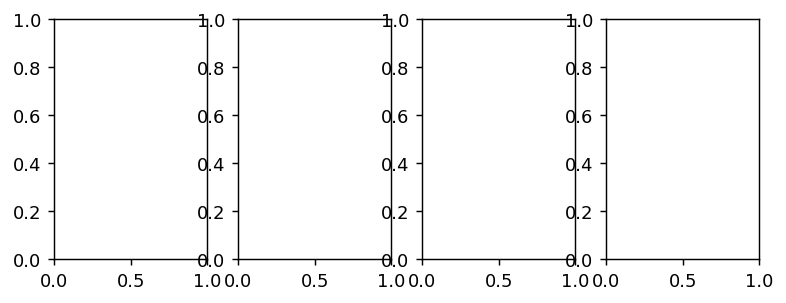

In [49]:
fig, [ax1, ax2, ax3, ax4] = plt.subplots(1, 4, figsize=(7, 2.4), dpi=130)


runs = load("wide_resnet_6k")
r = runs[0]

import dataset
x, y = dataset.get_normalized_dataset(r['args'].dataset, r['args'].data_seed)

y = y[r['args'].ptr: r['args'].ptr + r['args'].pte].clone()
y[y % 2 == 0] += 100
y, i = y.sort()
y[y % 2 == 0] -= 100

for ax, name in [(ax1, 'init_kernel'), (ax2, 'final_kernel')]:
    plt.sca(ax)
    k = r[name]['kernel']['test']['value']
    k = k[i][:, i] / k.norm() * k.numel() ** 0.5
    plt.imshow(k, vmin=0.1, vmax=1.9)

if r['args'].dataset == 'cifar10':
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
else:
    classes = [str(i) for i in range(10)]

for ax in [ax1, ax2]:
    plt.sca(ax)
    plt.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,        # ticks along the bottom edge are off
        right=False,       # ticks along the top edge are off
        bottom=False,
        top=False,
        labelbottom=False,
        labelleft=False) # labels along the bottom edge are off

    a = 0
    plt.xlim(-1 - a, len(y) + a)
    plt.ylim(len(y) + a, -1 - a)

plt.sca(ax1)


plt.sca(ax1)
plt.title(r'(a) RESNET')
plt.xlabel(r'$\Theta(w_0, x_i, x_j)$')

plt.sca(ax2)
plt.title(r'(b) RESNET')
plt.xlabel(r'$\Theta(w, x_i, x_j)$')




plt.sca(ax3)
runs = load("nd_M10d5L5kP")
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]

hs = sorted({r['args'].h for r in runs})
vs = [mean(err(r['init_kernel']['test']) for r in runs if r['args'].h == h) for h in hs]
plt.plot(hs, vs, label=r'init. ker.', color='k')

vs = [mean(err(r['final_kernel']['test']) for r in runs if r['args'].h == h) for h in hs]
plt.plot(hs, vs, label=r'final ker.')

vs = [mean(err(r['regular']['test']) for r in runs if r['args'].h == h) for h in hs]
plt.plot(hs, vs, label=r'vanilla')

plt.xscale('log')
plt.legend(labelspacing=0, frameon=False)
plt.xlabel('$h$')
plt.ylabel('test error', labelpad=-20)
plt.ylim(0.05, 0.19)
plt.xlim(hs[0], hs[-1])
y = [5, 7, 17, 19]
plt.yticks([y / 100 for y in y], [r'${}\%$'.format(y) for y in y])
plt.title('(c) FC relu')



plt.sca(ax4)
runs = load("nd_MCV5kP_3")
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) < 0.01 * r['args'].ptr]

hs = sorted({r['args'].h for r in runs})
vs = [mean(err(r['init_kernel']['test']) for r in runs if r['args'].h == h) for h in hs]
plt.plot(hs, vs, label=r'init. ker.', color='k')

vs = [mean(err(r['final_kernel']['test']) for r in runs if r['args'].h == h) for h in hs]
plt.plot(hs, vs, label=r'final ker.')

vs = [mean(err(r['regular']['test']) for r in runs if r['args'].h == h) for h in hs]
plt.plot(hs, vs, label=r'vanilla')

plt.xscale('log')
plt.legend(labelspacing=0, frameon=False)
plt.xlabel('$h$')
plt.ylim(0.02, 0.15)
plt.xlim(hs[0], hs[-1])
y = [2, 5, 10, 15]
plt.yticks([y / 100 for y in y], [r'${}\%$'.format(y) for y in y])
plt.title('(d) CNN relu')


plt.tight_layout(w_pad=0)
plt.savefig('kernel_dyn.pgf')

# Appendix Dynamics of the Weights

AttributeError: 'LatexManager' object has no attribute 'latex'

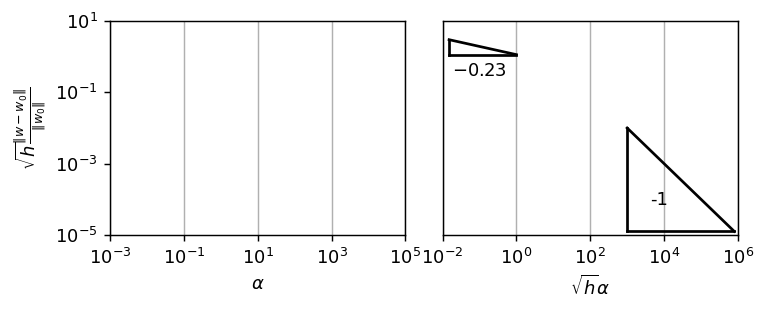

In [50]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(6, 2.5), dpi=130)

runs = load("F10k3Lsp_alpha")
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]

hs = sorted({r['args'].h for r in runs})

for h in hs:
    rs = [r for r in runs if r['args'].h == h]
    als = sorted({r['args'].alpha for r in rs})
    print([len([1 for r in rs if r['args'].alpha == a]) for a in als])
#     n = 10
#     rs = [r for rs in [[r for r in rs if r['args'].alpha == a] for a in als] if len(rs) >= n for r in rs[:n]]
#     als = sorted({r['args'].alpha for r in rs})

    ws = [a * h ** -0.5 for a in als]

    plt.sca(ax2)
    vs = [h ** 0.5 *
          mean(r['regular']['dynamics'][-1]['dnorm'] / r['regular']['dynamics'][0]['norm']
               for r in rs if r['args'].alpha == a) for a in als]
    plt.plot(als, vs, '-', label=r'$h = {}$'.format(h))


    plt.sca(ax1)
    vs = [h ** 0.5 *
          mean(r['regular']['dynamics'][-1]['dnorm'] / r['regular']['dynamics'][0]['norm']
               for r in rs if r['args'].alpha == a) for a in als]
    plt.plot(ws, vs, '-', label=r'$h = {}$'.format(h))




# y-axis
for ax in [ax1, ax2]:
    plt.sca(ax)
    plt.ylim(1e-5, 1e1)
    plt.yscale('log')

plt.sca(ax1)
plt.ylabel(r'$\sqrt{h} \frac{\| w - w_0 \|}{\|w_0\|}$')

plt.sca(ax2)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,        # ticks along the bottom edge are off
    right=False,       # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off


# x-axis
plt.sca(ax1)
plt.grid(axis='x')
plt.xlim(1e-3, 1e5)
plt.xscale('log')
plt.xlabel(r'$\alpha$')

plt.sca(ax2)
plt.grid(axis='x')
plt.xlim(1e-2, 1e6)
plt.xscale('log')
plt.xlabel(r'$\sqrt{h} \alpha$')

plt.sca(ax1)
plt.legend(labelspacing=0, frameon=False)

plt.sca(ax2)
triangle(1.5e-2, 1e0, 3, slope=-0.23, fmt="${:.2f}$", textpos=(1e-1, 4e-1))
triangle(1e3, 8e5, 1e-2, slope=-1, fmt="-1")

plt.tight_layout(w_pad=0)
plt.savefig('weights_scalings.pgf')

# Dynamics of the Output function

TypeError: load() got an unexpected keyword argument 'predicate'

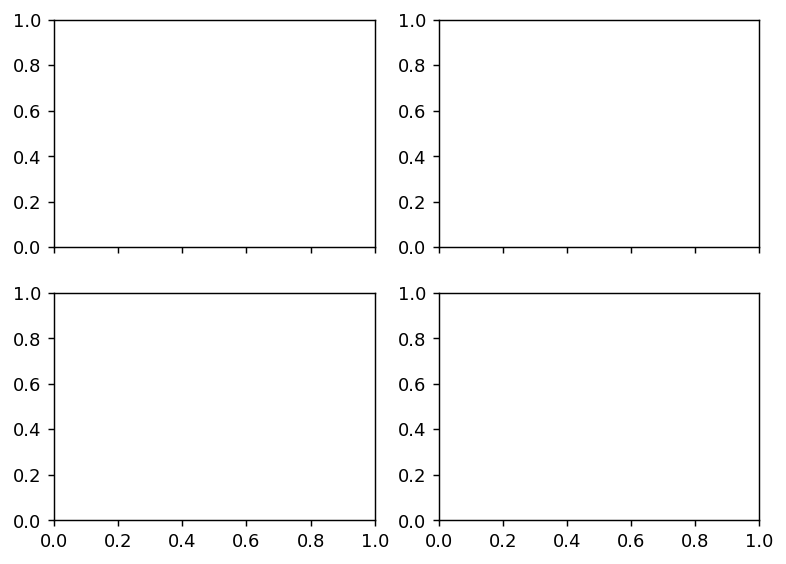

In [51]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(7, 5), dpi=130, sharex=True)

ti = torch.logspace(-3, 1, 100).numpy()


plt.sca(ax1)
h = 300
als = [1e-3, 1e-2, 1e-1, 1, 10]

runs = load('F10k3Lsp_alpha', predicate=lambda args: args.alpha in als and args.h == h)
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]

for a in als:
    rs = [r for r in runs if r['args'].h == h and r['args'].alpha == a]

    label = r'$\sqrt{{h}} \alpha={}$'.format(texnum(a))

    ts = []
    fs = []

    for r in rs:
        a = r['args'].alpha
        h = r['args'].h
        d = r['regular']['dynamics']
        t1 = next(x['t'] for x in d if x['train']['aloss'] < 0.5)

        t = [x['t'] / t1 for x in d]
        f = [x['test']['dfnorm'] for x in d]
        ts.append(t)
        fs.append(f)

    plt.plot(*yavg(ti, ts, fs), label=label)

plt.yscale('log')

plt.ylabel(r'$\|f(w_t) - f(w_0)\|$')
plt.ylim(3e-4*20, 3e2*20)

plt.xlabel(r'$t/t_1$')

plt.legend(frameon=False, labelspacing=0)

plt.title(r'(a) $h=' + str(h) + '$')




plt.sca(ax2)
a = 1e-2
hs = [100, 300, 1000]

runs = load('F10k3Lsp_alpha', predicate=lambda args: args.alpha == a and args.h in hs)
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]

for h in hs:
    rs = [r for r in runs if r['args'].h == h and r['args'].alpha == a]

    label = r'$h={}$'.format(h)

    ts = []
    fs = []

    for r in rs:
        a = r['args'].alpha
        d = r['regular']['dynamics']
        t1 = next(x['t'] for x in d if x['train']['aloss'] < 0.5)

        t = [x['t'] / t1 for x in d]
        f = [x['test']['fnorm'] / d[0]['test']['fnorm'] / h**0.5 for x in d]
        ts.append(t)
        fs.append(f)

    plt.plot(*yavg(ti, ts, fs), label=label)

plt.yscale('log')

plt.ylabel(r'$\frac{1}{\sqrt{h}} \|f(w_t)\| / \|f(w_0)\|$')
plt.ylim(1e-2, 1e3)

plt.xlabel(r'$t/t_1$')

plt.legend(frameon=False, labelspacing=0)

plt.title(r'(b) $\sqrt{h} \alpha=' + texnum(a) + '$')




for ax in [ax3, ax4]:
    plt.sca(ax)
    exp = 0 if ax == ax4 else 0.5

    als = [1e-2, 1e5]
    hs = [100, 300, 1000]

    runs = load('F10k3Lsp_alpha', predicate=lambda args: args.alpha in als and args.h in hs)
    runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]

    als = list(zip(als, ['-', '-.', '--', ':']))
    hs = list(zip(hs, plt.rcParams['axes.prop_cycle'].by_key()['color']))

    for a, linestyle in als:
        for h, color in hs:
            rs = [r for r in runs if r['args'].h == h and r['args'].alpha == a]

            label = r'$h={}$'.format(h)

            ts = []
            fs = []

            for r in rs:
                a = r['args'].alpha
                d = r['regular']['dynamics']
                t1 = next(x['t'] for x in d if x['train']['aloss'] < 0.5)

                t = [x['t'] / t1 for x in d]
                f = [a * x['test']['dfnorm'] * h**exp for x in d]
                ts.append(t)
                fs.append(f)

            plt.plot(*yavg(ti, ts, fs), color=color, linestyle=linestyle)

    plt.yscale('log')

    if exp == 0.5:
        plt.ylabel(r'$\sqrt{h} \alpha \|f(w_t) - f(w_0)\|$')
        plt.ylim(3e-4, 1e2)
    if exp == 0.0:
        plt.ylabel(r'$\alpha \|f(w_t) - f(w_0)\|$')
        plt.ylim(3e-5, 1e1)

    plt.xlabel(r'$t/t_1$')

    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color=color) for h, color in hs] + [Line2D([0], [0], color='k', linestyle=linestyle) for a, linestyle in als]
    texts = [r'$h={}$'.format(h) for h, color in hs] + [r'$\sqrt{{h}} \alpha={}$'.format(texnum(a)) for a, linestyle in als]
    plt.legend(custom_lines, texts, frameon=False, labelspacing=0, loc=4)

plt.sca(ax3)
plt.title(r'(c)')

plt.sca(ax4)
plt.title(r'(d)')

plt.sca(ax1)
triangle(2e-2, 2e-1, 1.6e-2, slope=1, fmt="1")

plt.xscale('log')
plt.xlim(1e-2, 1e1)

plt.tight_layout()
plt.savefig('dfnorm.pgf')

# Preactivation evolution

<ipython-input-52-fbbb3de55124>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  hs, ds = torch.load('dot_z.pkl', map_location='cpu')


FileNotFoundError: [Errno 2] No such file or directory: 'dot_z.pkl'

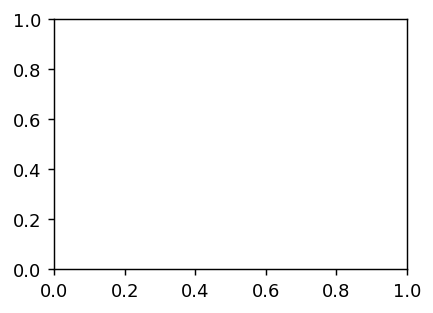

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2.5), dpi=130)

hs, ds = torch.load('dot_z.pkl', map_location='cpu')

for i in range(ds[0].size(0)):
    plt.plot(hs, [x[i] for x in ds], '.-', label='$\ell={}$'.format(i + 1))

plt.legend(labelspacing=0, frameon=False)

plt.xscale('log')
plt.yscale('log')
plt.xlim(min(hs), max(hs))
plt.ylim(1e-3, 1e-1)

triangle(3800, 150, 1.1e-3, slope=-1/2, fmt='-1/2', other=True)

plt.xlabel('$h$')
plt.ylabel(r'$\sqrt{\frac{1}{n} \sum_\mu \frac{1}{h} \sum_i \dot{\tilde{z}}^\ell_i (x_\mu) ^2}$')
plt.title('FC softplus')

plt.tight_layout()
plt.savefig('dot_z.pgf')

# Relu

In [53]:
runs = load("nd_M10d5L5kP_alpha_4")
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]

fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=130)

def thth0(r):
    x = r['init_kernel']['kernel']['test']
    th0 = x['diag'].numel() * (x['mean'] ** 2 + x['std'] ** 2) ** 0.5
    dth = r['delta_kernel']['test']
    return dth / th0

hs = sorted({r['args'].h for r in runs})
hs = [50, 200, 800]

for h in hs:
    rs = [r for r in runs if r['args'].h == h]
    als = sorted({r['args'].alpha for r in rs})
    print([len([1 for r in rs if r['args'].alpha == a]) for a in als])
    n = 3
    rs = [r for rs in [[r for r in rs if r['args'].alpha == a] for a in als] if len(rs) >= n for r in rs[:n]]
    als = sorted({r['args'].alpha for r in rs})

    ws = [a * h ** 0.5 for a in als]
    vs = [mean(thth0(r) for r in rs if r['args'].alpha == a) for a in als]

    plt.plot(ws, vs, '-', label=r'$h = {}$'.format(h))

# y-axis
plt.yscale('log')
plt.ylim(1e-12, 1e7)
plt.ylabel(r'$\frac{\|\Theta - \Theta_0\|}{\|\Theta_0\|}$')

# x-axis
plt.grid(axis='x')
plt.xlim(1e-2, 1e11)
plt.xscale('log')
plt.xlabel(r'$\sqrt{h} \alpha$')

plt.legend(labelspacing=0, frameon=False)

triangle(1.5e-2, 5e0, 3e5, slope=-1.7, fmt=r"${:.1f}$")
triangle(2e2, 1e6, 1e-2, slope=-1/2, other=False, fmt="-1/2")
triangle(1e7, 1e10, 1e-7, slope=-1, other=False, fmt="-1")

plt.tight_layout()
plt.savefig('relu_th.pgf')

NotADirectoryError: nd_M10d5L5kP_alpha_4 does not exists

# Appendix gradflow

python -m grid F10k3Lsp_alpha_gradflow --n 32 "srun --partition gpu --qos gpu --gres gpu:1 --time 09:00:00 --mem 12G python main.py --data_seed 0 --batch_seed 0 --init_kernel 1 --final_kernel 1 --delta_kernel 1 --pte 50000 --arch fc_softplus --L 3 --spbeta 5 --train_time 18000 --ptr 10000 --max_dout 0.1 --dataset fashion --lossbeta 20 --max_dgrad 1e-6" --init_seed 0 1 2 3 4 --alpha 1e-4 3.2e-4 1e-3 3.2e-3 1e-2 3.2e-2 1e-1 3.2e-1 1e0 3.2e0 1e1 3.2e1 1e2 3.2e2 1e3 3.2e3 1e4 3.2e4 1e5 3.2e5 1e6 3.2e6 1e7 --h:int 100

NotADirectoryError: F10k3Lsp_alpha_gradflow does not exists

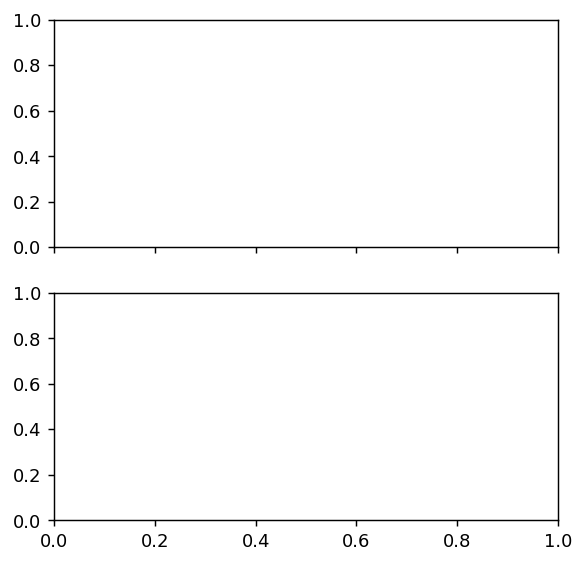

In [54]:
fig, [ax1, ax3] = plt.subplots(2, 1, figsize=(5, 5), dpi=130, sharex=True)


plt.sca(ax1)

runs1 = load('F10k3Lsp_alpha_gradflow')
runs1 = [r for r in runs1 if nd(r['regular']['train'], r['args'].alpha) == 0]

runs2 = load('F10k3Lsp_alpha/', predicate=lambda args: args.h == 100 and args.init_seed < 5)

ais1 = {(r['args'].alpha, r['args'].init_seed) for r in runs1}
ais2 = {(r['args'].alpha, r['args'].init_seed) for r in runs2}
ais = ais1.intersection(ais2)

als = sorted({a for a, i in ais})
runs = [
    [
        (
            next(r for r in runs1 if (r['args'].alpha, r['args'].init_seed) == (a, i)),
            next(r for r in runs2 if (r['args'].alpha, r['args'].init_seed) == (a, i))
        )
        for i in [i for aa, i in ais if aa == a]
    ]
    for a in als
]

print([len(rs) for rs in runs])

vs = [mean(
    (r1['regular']['test']['outputs'] - r2['regular']['test']['outputs']).pow(2).mean().sqrt()
    / r1['regular']['test']['outputs'].pow(2).mean().sqrt()
    for r1, r2 in rs) for a, rs in zip(als, runs)]
plt.plot(als, vs, '.-')

plt.xscale('log')
plt.yscale('log')

plt.ylabel(r'$\frac{\| f_{\epsilon_\nabla=10^{-6}} - f_{\epsilon_\nabla=10^{-4}} \|}{\| f_{\epsilon_\nabla=10^{-6}} \|}$')





plt.sca(ax3)

runs = load('F10k3Lsp_alpha_gradflow')
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]
label = r'$\epsilon_\nabla = 10^{-6}$'
als = sorted({r['args'].alpha for r in runs})
vs = [mean(r['regular']['dynamics'][-1]['wall'] for r in runs if r['args'].alpha == a) for a in als]
plt.plot(als, vs, label=label)

runs = load('F10k3Lsp_alpha', predicate=lambda args: args.h == 100)
label = r'$\epsilon_\nabla = 10^{-4}$'
als = sorted({r['args'].alpha for r in runs})
vs = [mean(r['regular']['dynamics'][-1]['wall'] for r in runs if r['args'].alpha == a) for a in als]
plt.plot(als, vs, label=label)

plt.xscale('log')
plt.legend(frameon=False, labelspacing=0)
plt.xlabel(r'$\sqrt{h}\alpha$')
plt.ylabel('seconds of computation time')
plt.xlim(min(als), max(als))
plt.ylim(0, None)


for ax, le in zip([ax1, ax3], 'abcd'):
    plt.sca(ax)
    plt.title("({})".format(le))

plt.tight_layout()
plt.savefig('sanity_check.pgf')

# Appendix Variance Lazy size of dataset

python -m grid F3Lsp_p_h --n 20 "srun --partition gpu --qos gpu --gres gpu:1 --time 09:00:00 --mem 12G python main.py --data_seed 0 --batch_seed 0 --init_kernel 0 --final_kernel 0 --delta_kernel 0 --pte 50000 --arch fc_softplus --L 3 --spbeta 5 --train_time 18000 --max_dout 0.1 --dataset fashion --tau_alpha_crit 1e3 --lossbeta 20 --tau_over_h 1e-3 --max_dgrad 1e-4 --alpha 1e6" --init_seed 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 --ptr:int 250 500 1000 2000 4000 --h:int 14 19 27 37 52 72 100 139 193 268 373 518 720 1000 1390

TypeError: load() got an unexpected keyword argument 'predicate'

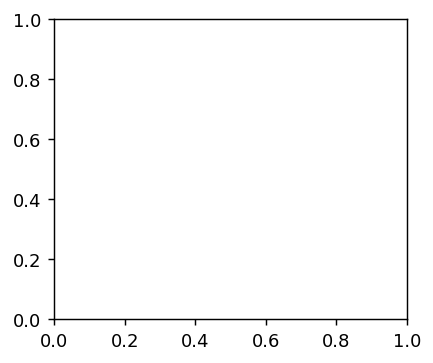

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3), dpi=130, sharex=True)

a = 1e6
runs = load('F3Lsp_p_h', predicate=lambda args: args.alpha == a)
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]
ps = sorted({r['args'].ptr for r in runs})
ps = [500, 1000, 2000, 4000]

for p in ps:
    rs = [r for r in runs if r['args'].ptr == p]
    label = r'$n={}$'.format(p)
    hs = sorted({r['args'].h for r in rs})
    print([len([1 for r in rs if r['args'].h == h]) for h in hs])
    rs = [r for rs in [[r for r in rs if r['args'].h == h] for h in hs] if len(rs) >= 2 for r in rs]
    hs = sorted({r['args'].h for r in rs})

    print(p)
    vs = [p ** -0.5 * var([r['regular']['test']['outputs'] for r in rs if r['args'].h == h], a) for h in hs]
    plt.plot(hs, vs, label=label)

plt.xlim(min(r['args'].h for r in runs), max(r['args'].h for r in runs))
plt.legend(labelspacing=0, frameon=False)
plt.xlabel(r'$h$')
plt.ylabel(r'$\mathrm{Var}[\alpha (f - f_0)] / \sqrt{p}$')
plt.yscale('log')
plt.xscale('log')

triangle(5e1, 3e2, 9e-3, slope=-0.5, fmt='-1/2')
triangle(1e3, 3e3, 2e-3, slope=-1, fmt='-1')

plt.tight_layout()
plt.savefig('var_p.pgf')